In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        # "/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",
        "/Users/louis/Data/JWST/amigo_data/calibrators/train_set/",
    ],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    **kwargs,
)

files = (
    [] + 
    file_fn(FILTER="F380M")[:1] +
    file_fn(FILTER="F430M")[:1] +
    file_fn(FILTER="F480M")[1:2]
)

# files = files[:1]

# files = file_fn()

# files = file_fn(FILTER="F480M")

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



3
  TARGPROP: HD-18638, -GAM-MUS, HD-40733
  FILTER: F380M, F430M, F480M
  NINTS: 4869, 5101, 4750
  NGROUPS: 8, 3
  OBSERVTN: 002, 001, 010
  NCHUNKS: 1


In [19]:
import jax.numpy as np

for file in files:
    # file["SCI"].data[:, :, -1:] = np.nan
    # file["SCI_VAR"].data[:, :, -1:] = np.nan
    # file["ZPOINT"].data[:, -1:] = np.nan
    # file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

jw01508001001_03102_00001_0001_nis_calslope.fits
4750
3
4757.78377736337


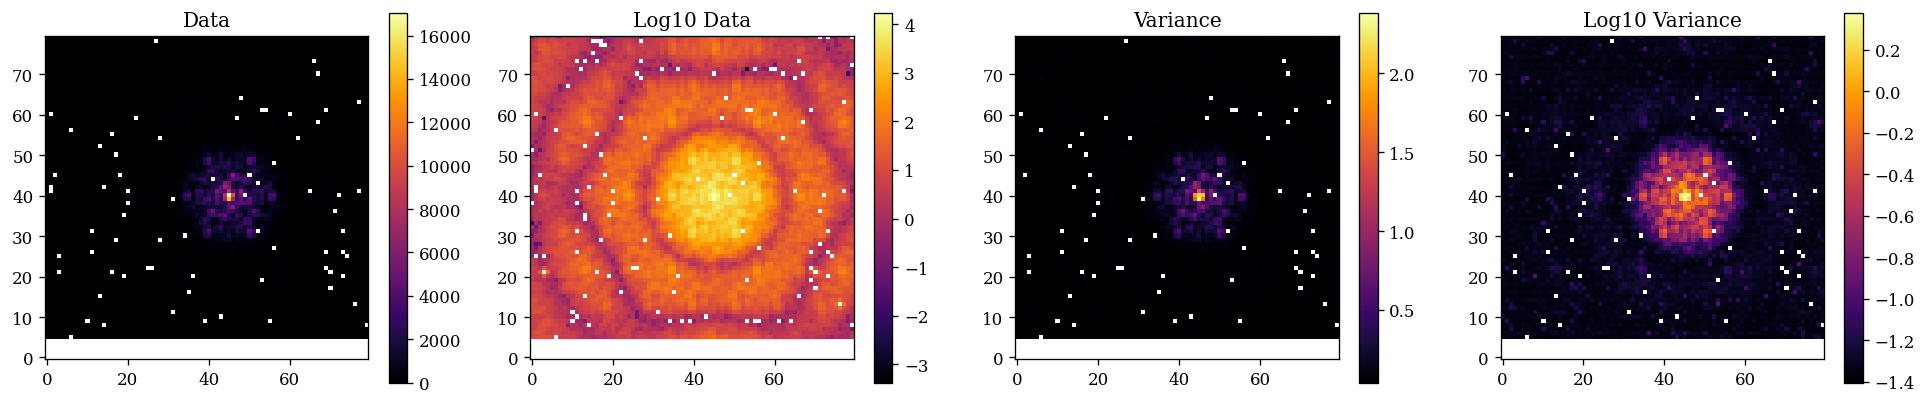

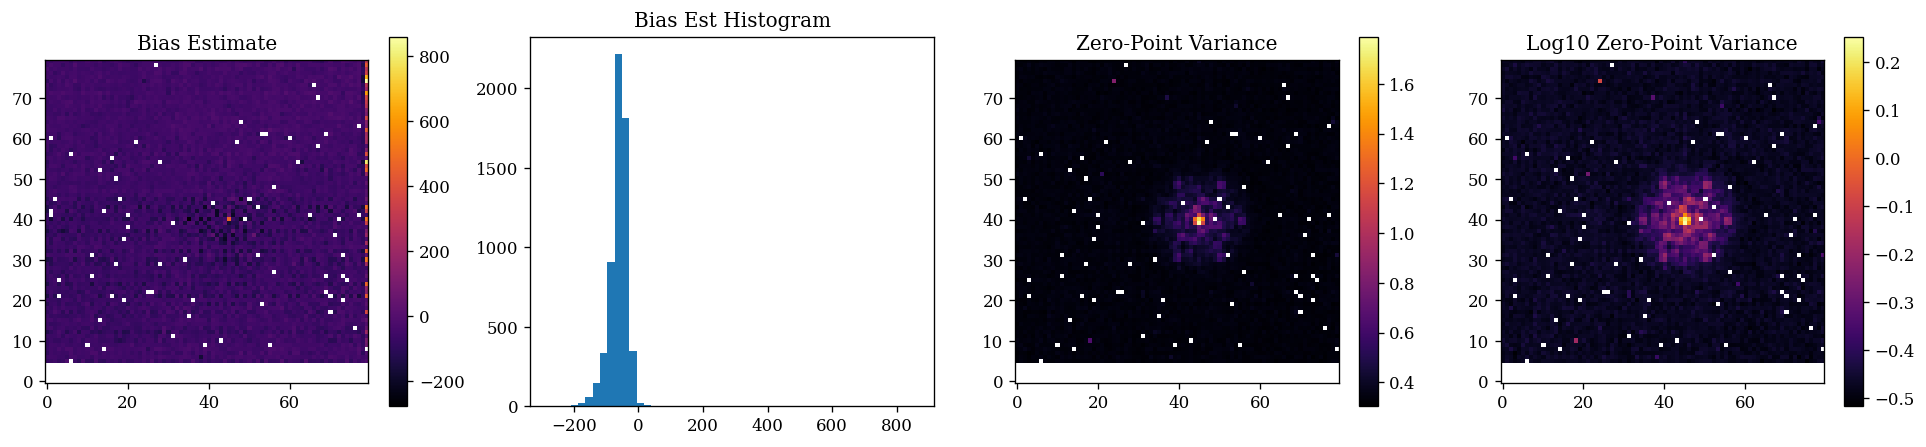

jw02297002001_03108_00001_0001_nis_calslope.fits
5101
3
7379.003766556812


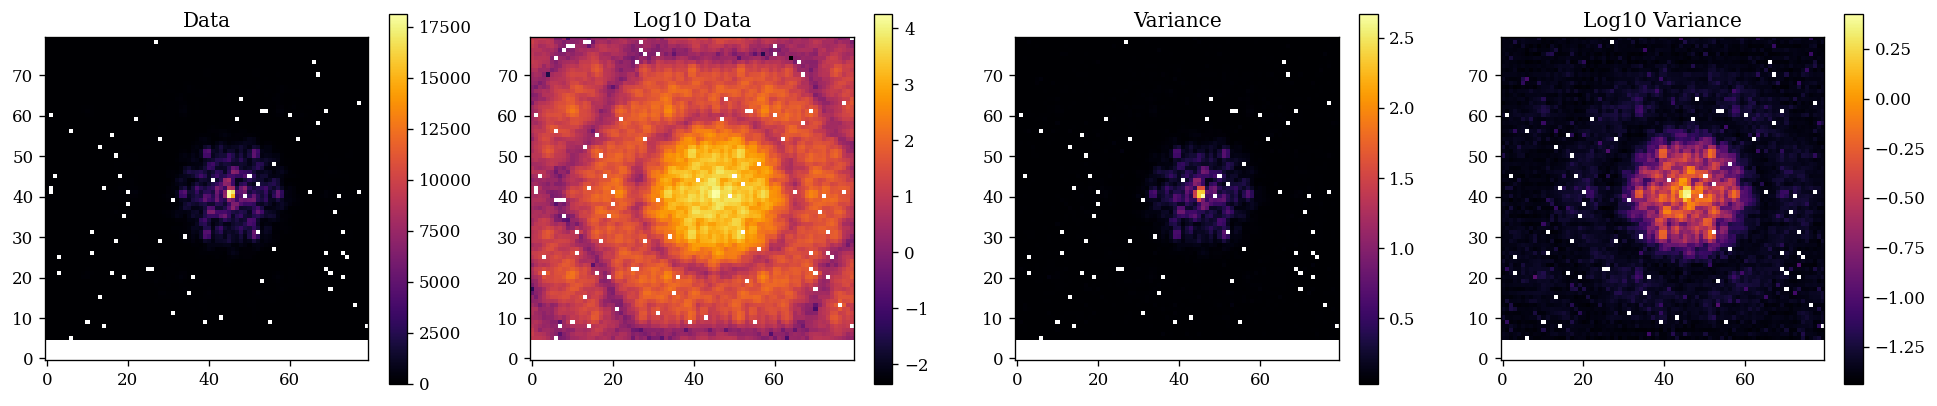

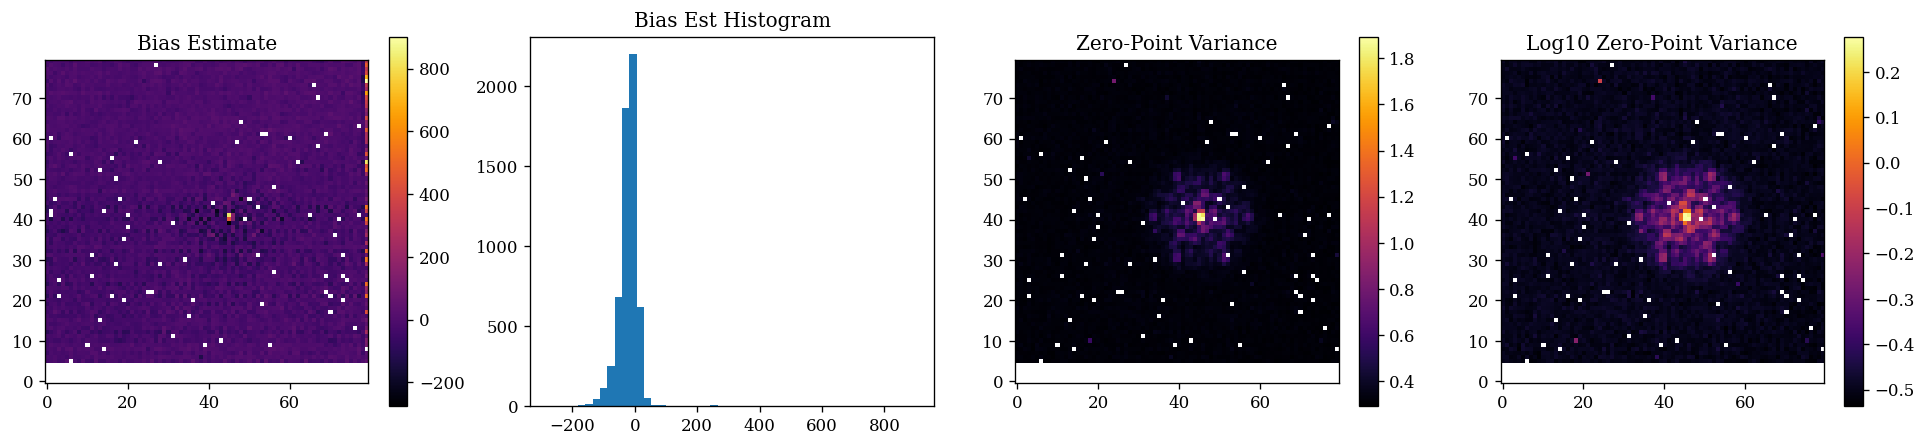

jw01242010001_03102_00001_0001_nis_calslope.fits
4869
8
2429.4375784498416


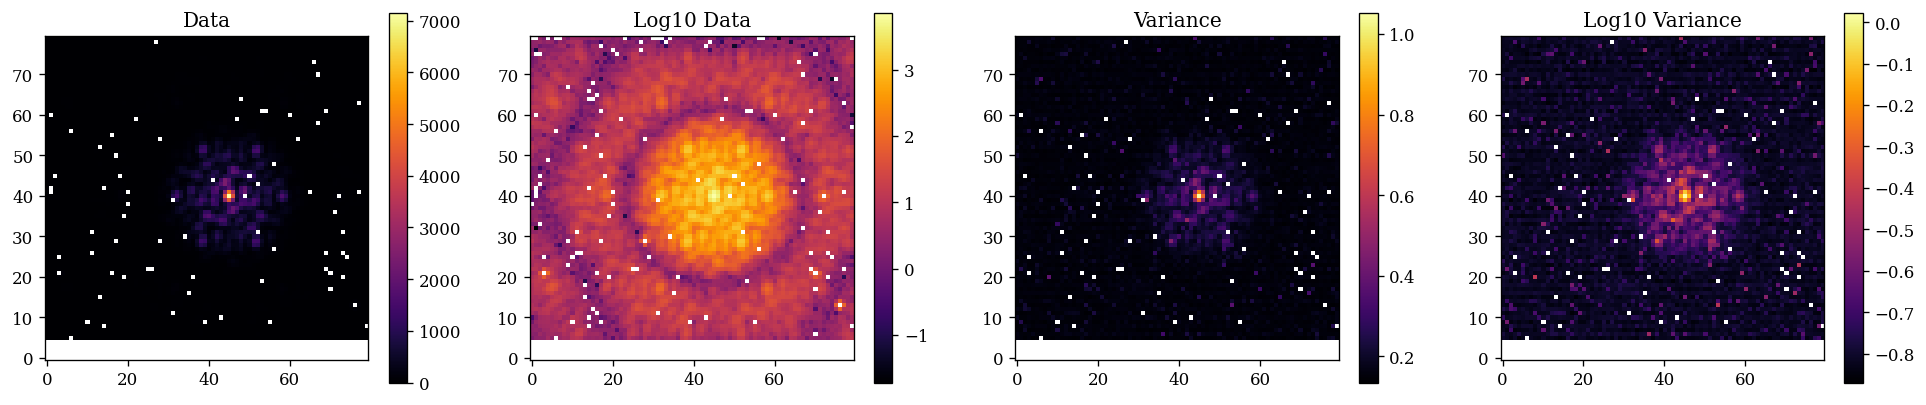

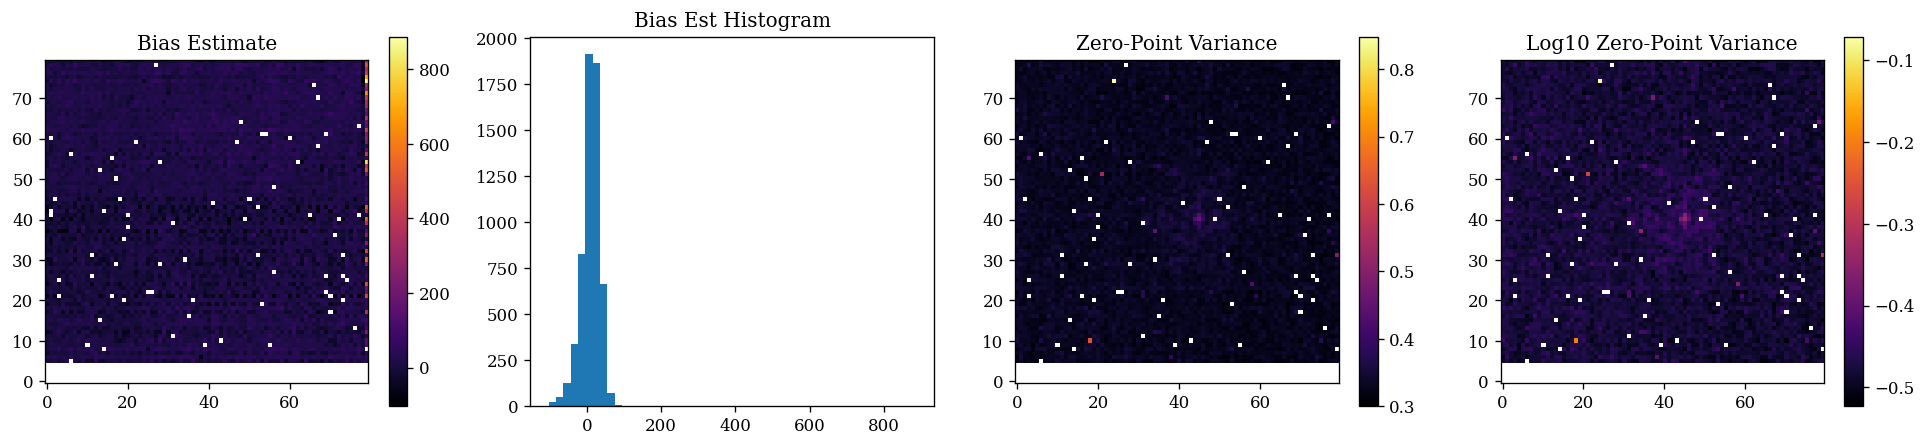

In [20]:
import jax.numpy as np

for file in files:
    print(file[0].header["FILENAME"])
    nints = file[0].header["NINTS"]
    ngroups = file[0].header["NGROUPS"]
    print(nints)
    print(ngroups)

    # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
    data = np.sum(np.asarray(file["SCI"].data, float), 0)
    var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)

    nphot_per_im = np.nansum(data)
    nphot_tot = nints * nphot_per_im
    print(nphot_tot * 1e-6)

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.title("Data")
    plt.imshow(data)
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("Log10 Data")
    plt.imshow(np.log10(data))
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.title("Variance")
    # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
    plt.imshow(var)
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("Log10 Variance")
    # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
    plt.imshow(np.log10(var))
    plt.colorbar()
    plt.show()

    # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
    psf_est = np.asarray(file["SCI"].data, float)[0]
    # var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)
    zpoint = np.asarray(file["ZPOINT"].data, float)
    zpoint_var = np.asarray(file["ZPOINT_VAR"].data, float)

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.title("Bias Estimate")
    plt.imshow(zpoint - psf_est)
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("Bias Est Histogram")
    # plt.imshow(np.log10(zpoint - psf_est))
    plt.hist((zpoint - psf_est).flatten(), bins=50)

    plt.subplot(1, 4, 3)
    plt.title("Zero-Point Variance")
    # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
    plt.imshow(zpoint_var)
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("Log10 Zero-Point Variance")
    # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
    plt.imshow(np.log10(zpoint_var))
    plt.colorbar()
    plt.show()

In [21]:
import jax.numpy as np
from amigo.core import AmigoModel
from amigo.optics import AMIOptics
from amigo.detectors import LinearDetectorModel, ReadModel, SimpleRamp
from amigo.files import get_exposures, initialise_params

optics = AMIOptics()
detector = LinearDetectorModel()
ramp_model = SimpleRamp()
read_model = ReadModel()

# Prep the model
exposures = get_exposures(files)
params = initialise_params(exposures, optics)

# Add the binary parameters
model = AmigoModel(files, params, optics=optics)

In [6]:
model.Teffs

{'-GAM-MUS': Array(15134.593, dtype=float32),
 'HD-40733': Array(4914.048, dtype=float32),
 'HD-18638': Array(4514.151, dtype=float32)}

In [7]:
from amigo.non_linear import PolyNonLin

polyEDM = PolyNonLin()
model = model.set("ramp", polyEDM)

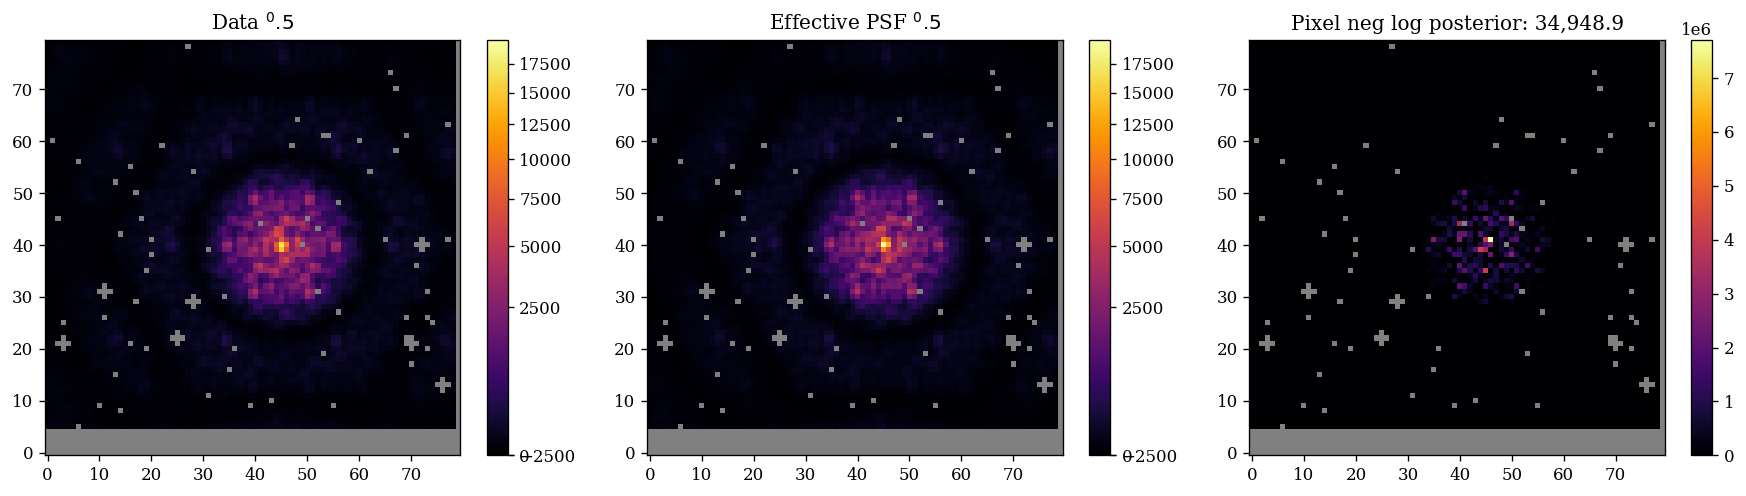

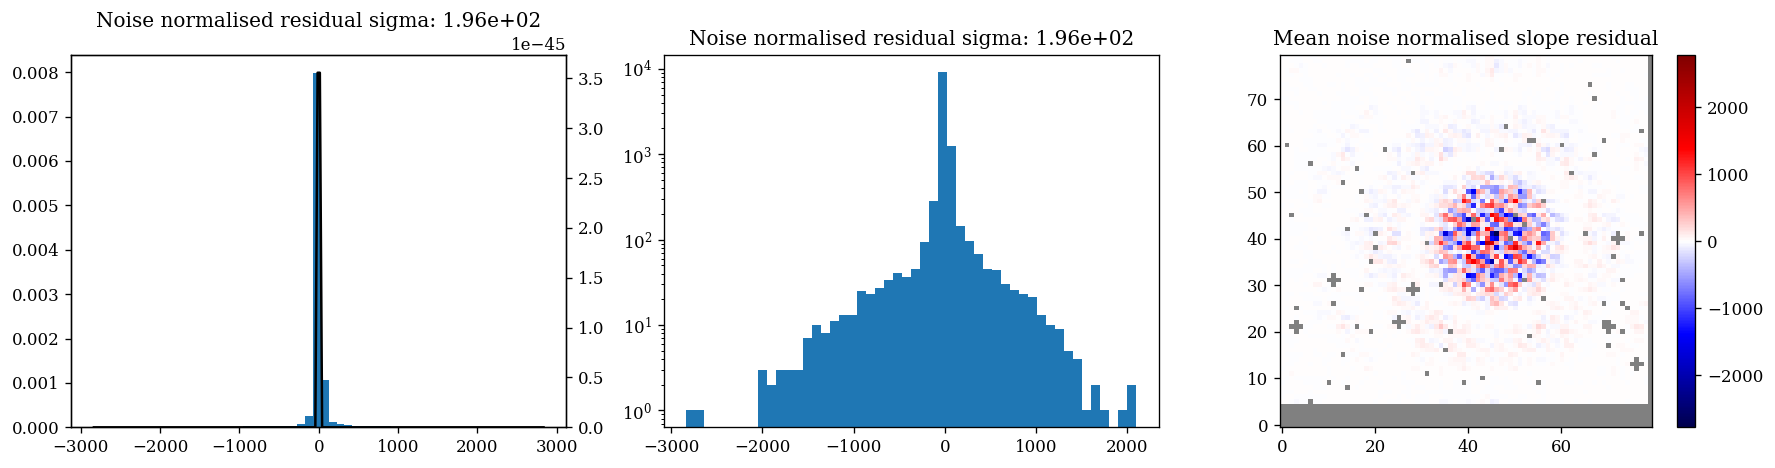

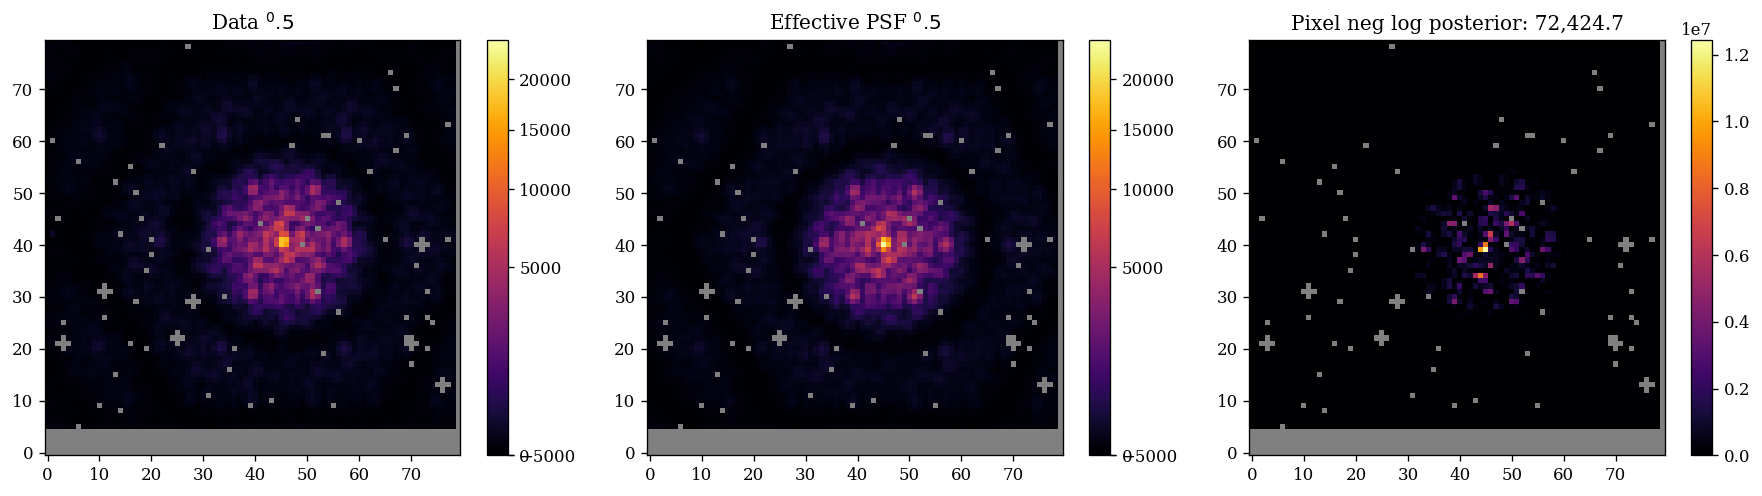

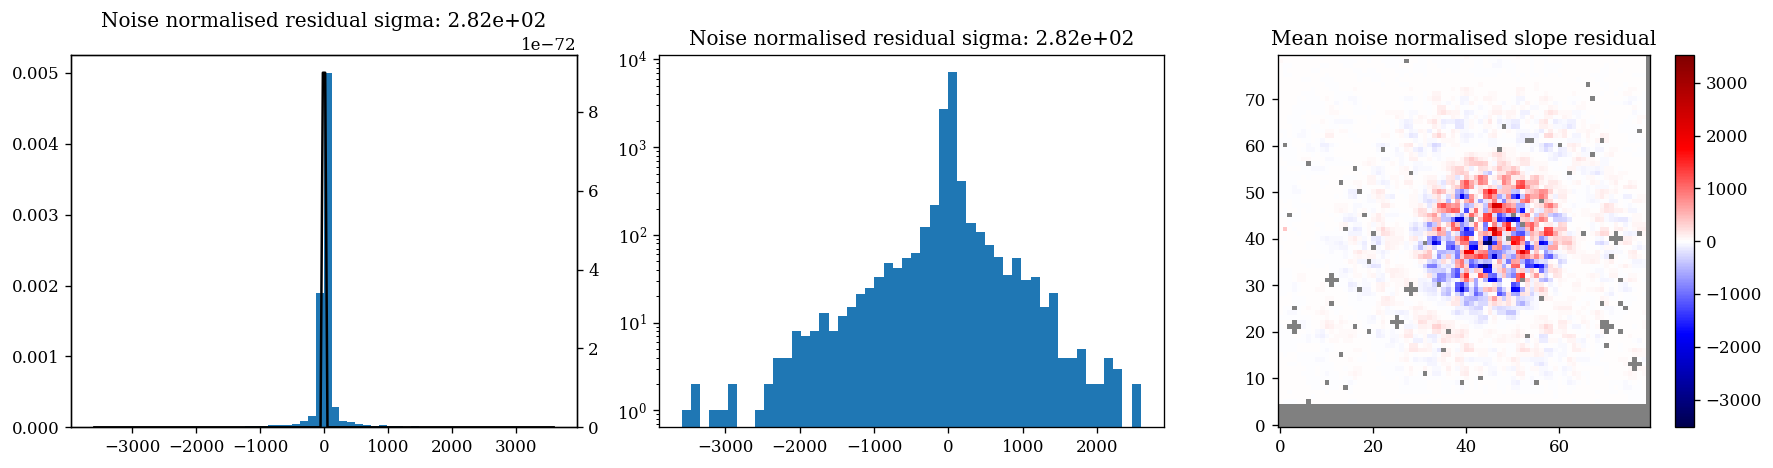

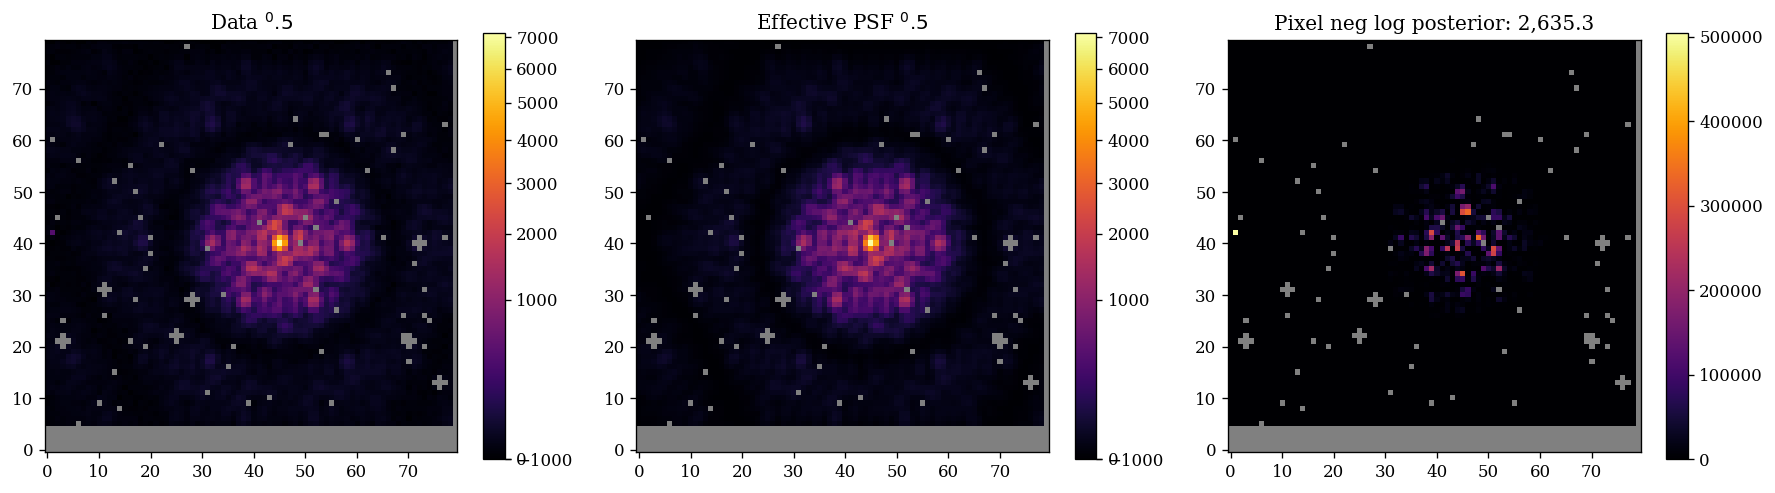

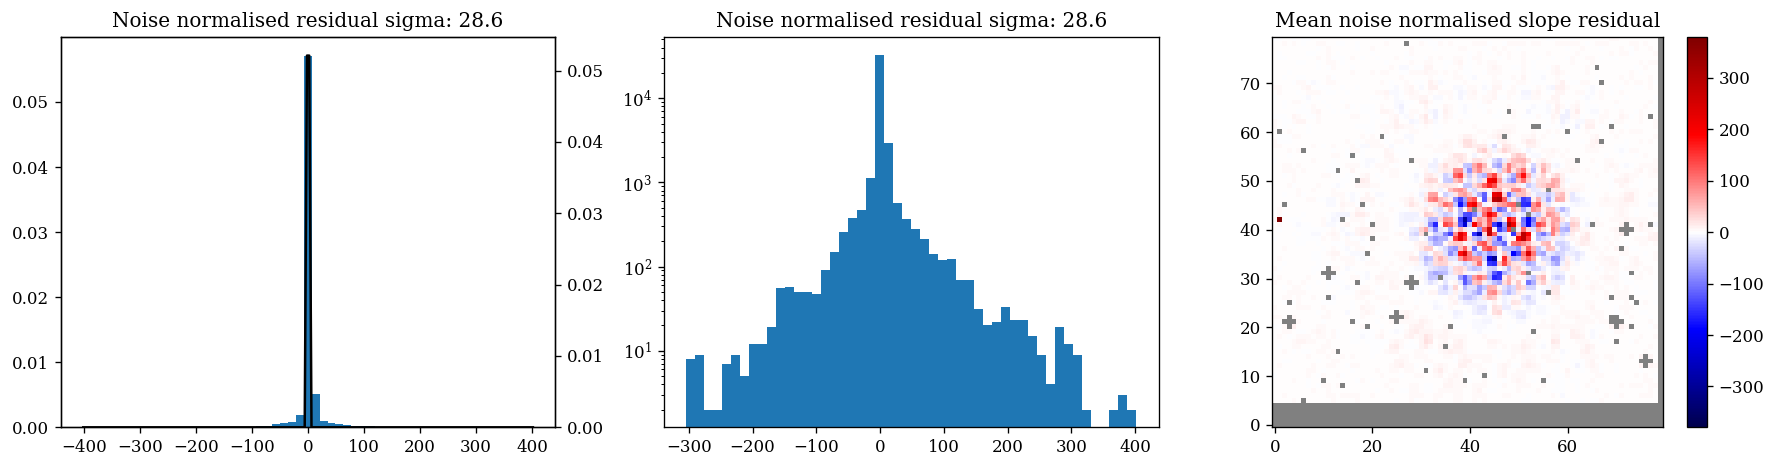

In [8]:
from amigo.plotting import summarise_fit
for exp in exposures:
    summarise_fit(exp, model, residuals=True, histograms=True)

In [9]:
from amigo.fisher import calc_fishers

params = [
    "positions",
    "aberrations",
    "fluxes",
    "one_on_fs",
    "rotation",
    "compression",
    "shear",
    "translation",
    "f2f",
    "holes",
    "dark_current",
    "jitter.r",
    # "jitter.shear",
    # "jitter.phi",
    # "ramp.coeffs",
    # "anisotropy.compression",
    # "SRF",
    # "ipc",
    # "FF",
]
model = model.set("ramp", None)
fishers = calc_fishers(model, exposures, params)
model = model.set("ramp", polyEDM)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

2024-06-10 23:59:30.442937: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2495, f64[] %constant.150), window={size=1x32x32 stride=1x32x32}, to_apply=%region_1.103

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-10 23:59:30.575766: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.136772s
Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2495, f64[] %constant.150), window={size=1

In [10]:
def grad_fn(model, grads, args, key):
    # grads = jax.tree_map(lambda x: np.where(np.isnan(x), 0.0, x), grads)
    if grads.holes is not None:
        grads = grads.set("holes", grads.holes * np.ones((7, 2)).at[:3, :].set(0))
    return grads, key

In [11]:
from amigo.fitting import optimise
import jax.random as jr
import optax

def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

batch_size = 1
nbatch = len(exposures) // batch_size
if len(exposures) % batch_size != 0:
    nbatch += 1
optimisers = {
    "positions": sgd(5e-1, 0),
    "aberrations": sgd(5e-2, 5),
    "fluxes": sgd(2e-1, 10),
    "shear": sgd(2e-1, 15),
    "rotation": sgd(2e-1, 15),
    "compression": sgd(2e-1, 15),
    "translation": sgd(5e-2, 15),
    "f2f": sgd(2e-1, 15),
    "dark_current": sgd(2e-1, 20),
    "jitter.r": sgd(5e-1, 20),
    # "jitter.shear": sgd(5e-1, 20),
    # "jitter.phi": sgd(1e0, 20),
    "holes": sgd(2e-1, 25),
    # "ramp.coeffs": adam(5e-6, 30 * nbatch),
    "ramp.coeffs": sgd(2e-12, 30 * nbatch),
    "one_on_fs": sgd(0, 10),
}


model = model.set("ramp", polyEDM)


# Optimisation
final_model, losses, histories, states = optimise(
    model,
    exposures,
    optimisers,
    epochs=100,
    key=jr.PRNGKey(0),
    fishers=fishers,
    grad_fn=grad_fn,
    print_grads=False,
    batch_size=batch_size,
    batch_params=["ramp.coeffs"],
)

  0%|          | 0/100 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Grad Batch fn compiling...
Grad Batch fn compiling...
Compiling update function
Compile Time: 0:00:30
Initial Loss: 40,254.86
Est time per epoch:  0:00:13
Est run remaining:  0:22:37
Full Time: 0:22:53
Final Loss: 247.03


247.02719571969854 [136.38098772 214.81376069 389.88683875]


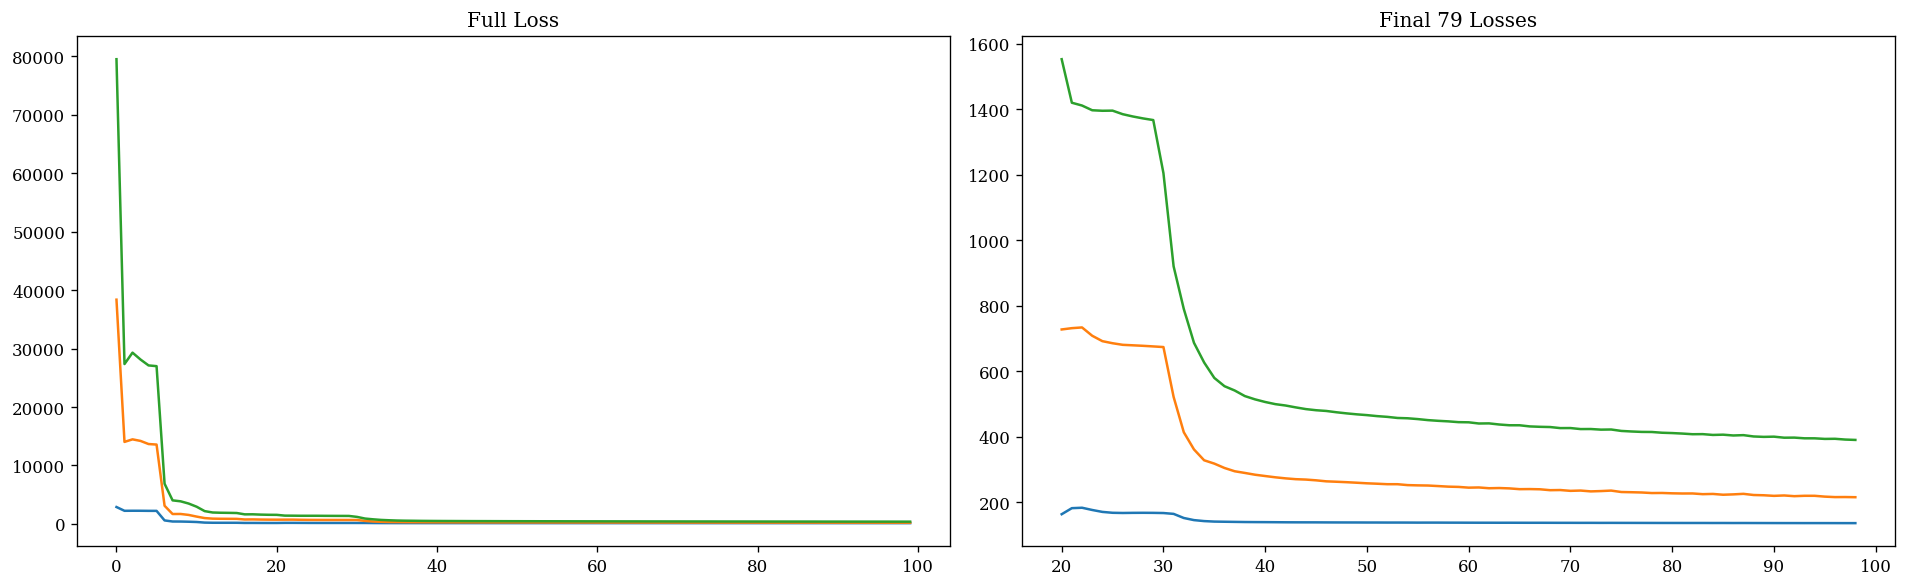

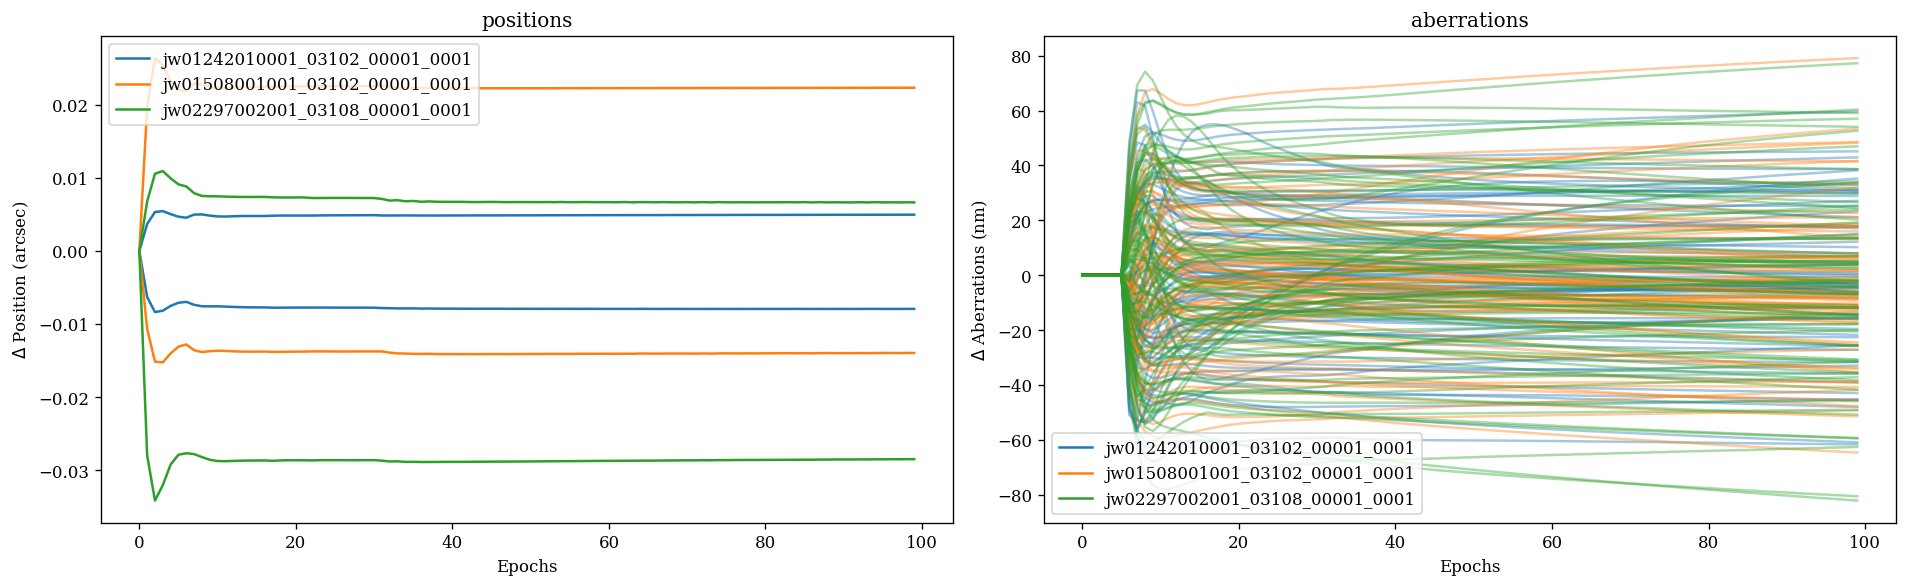

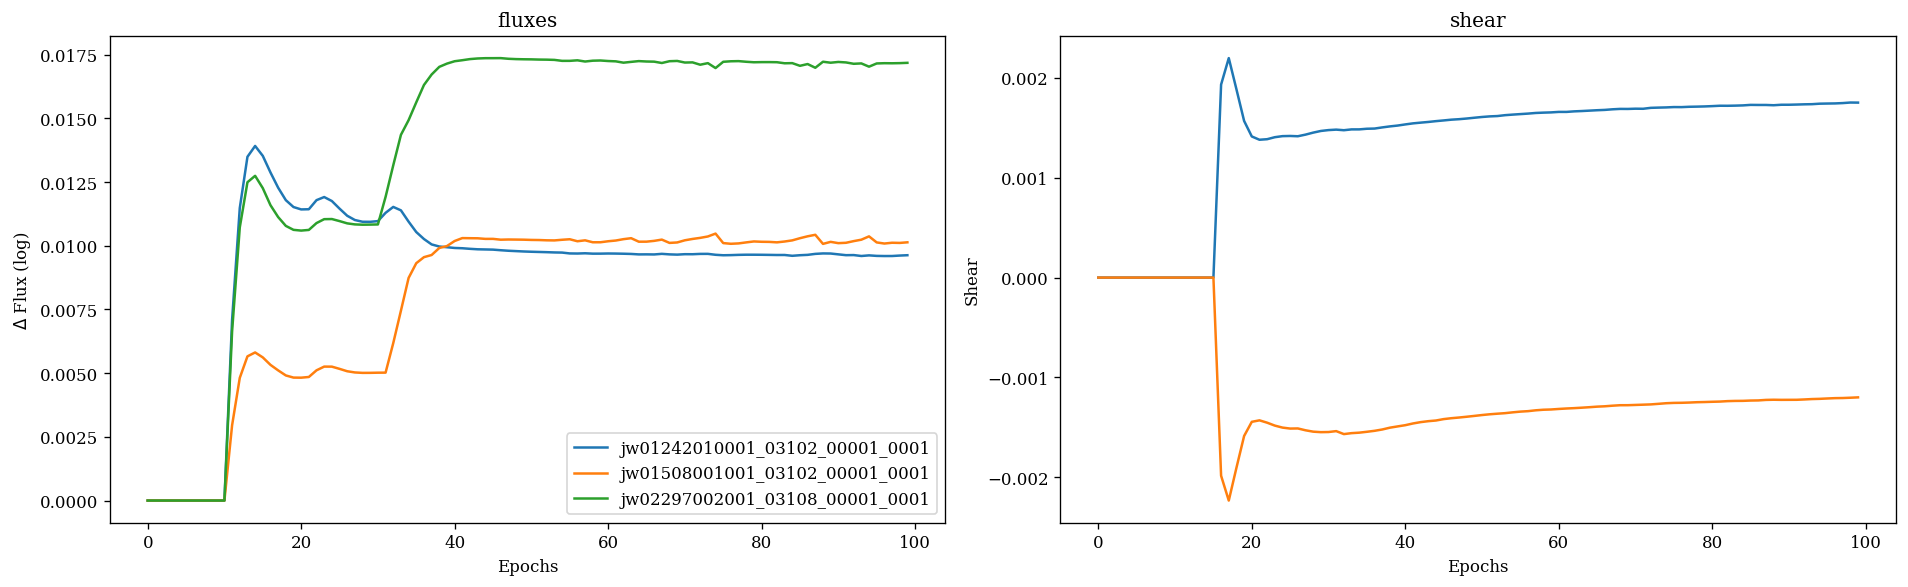

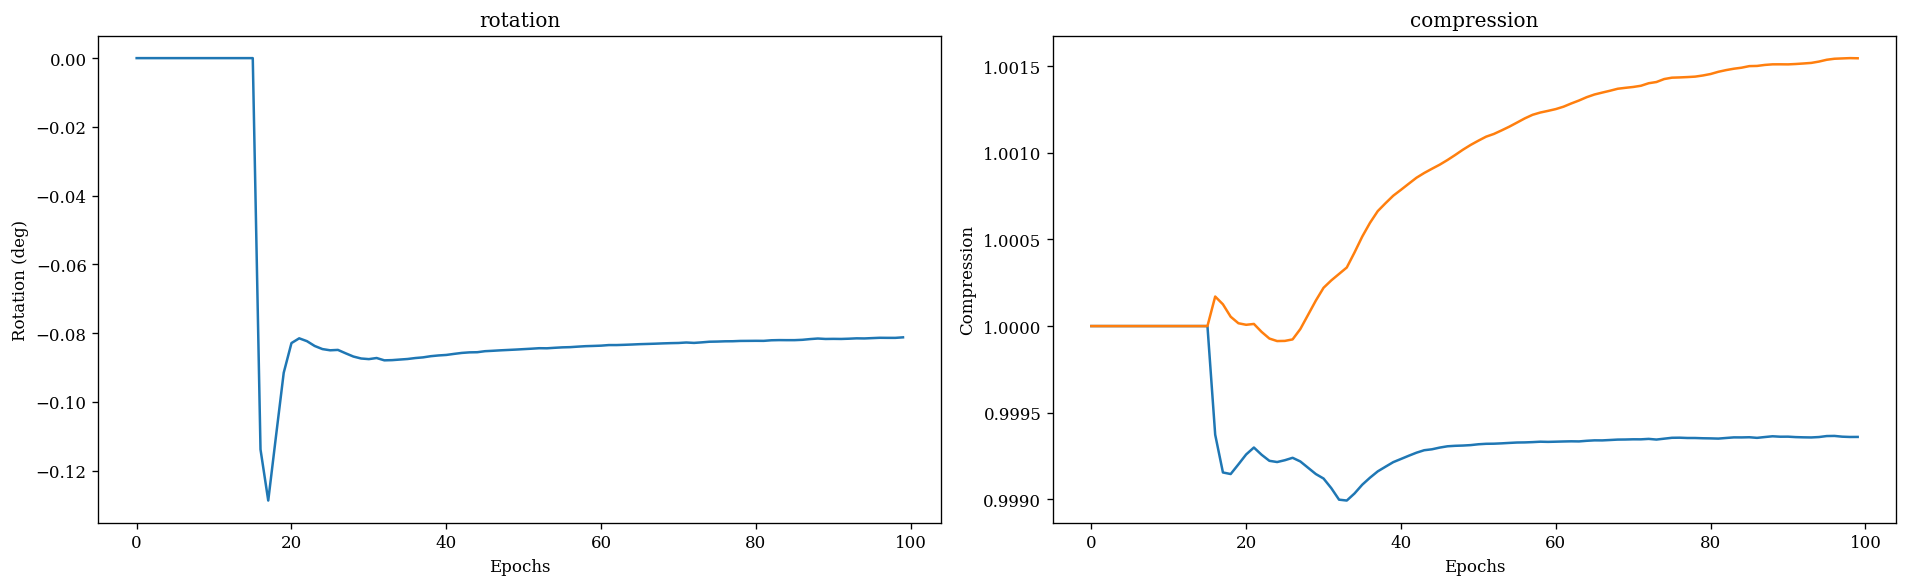

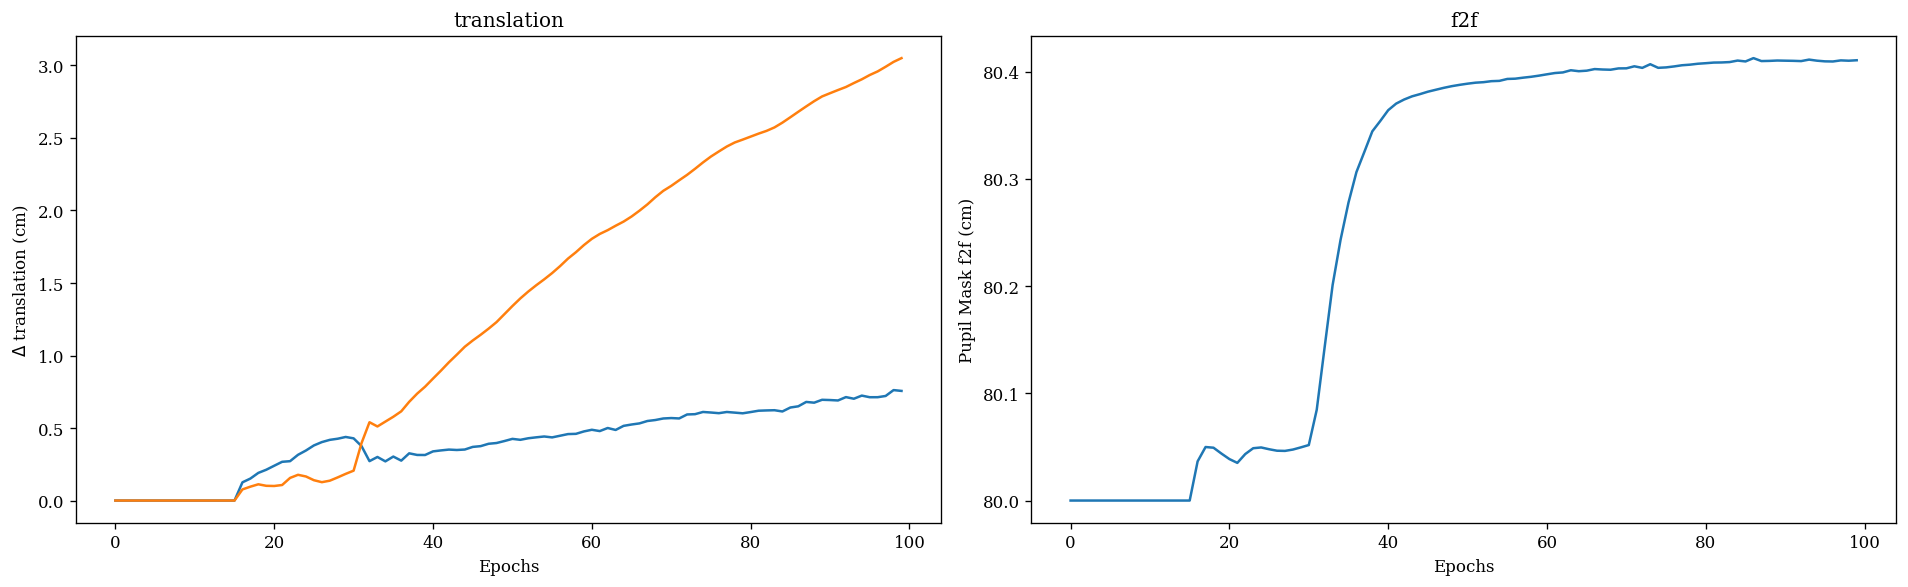

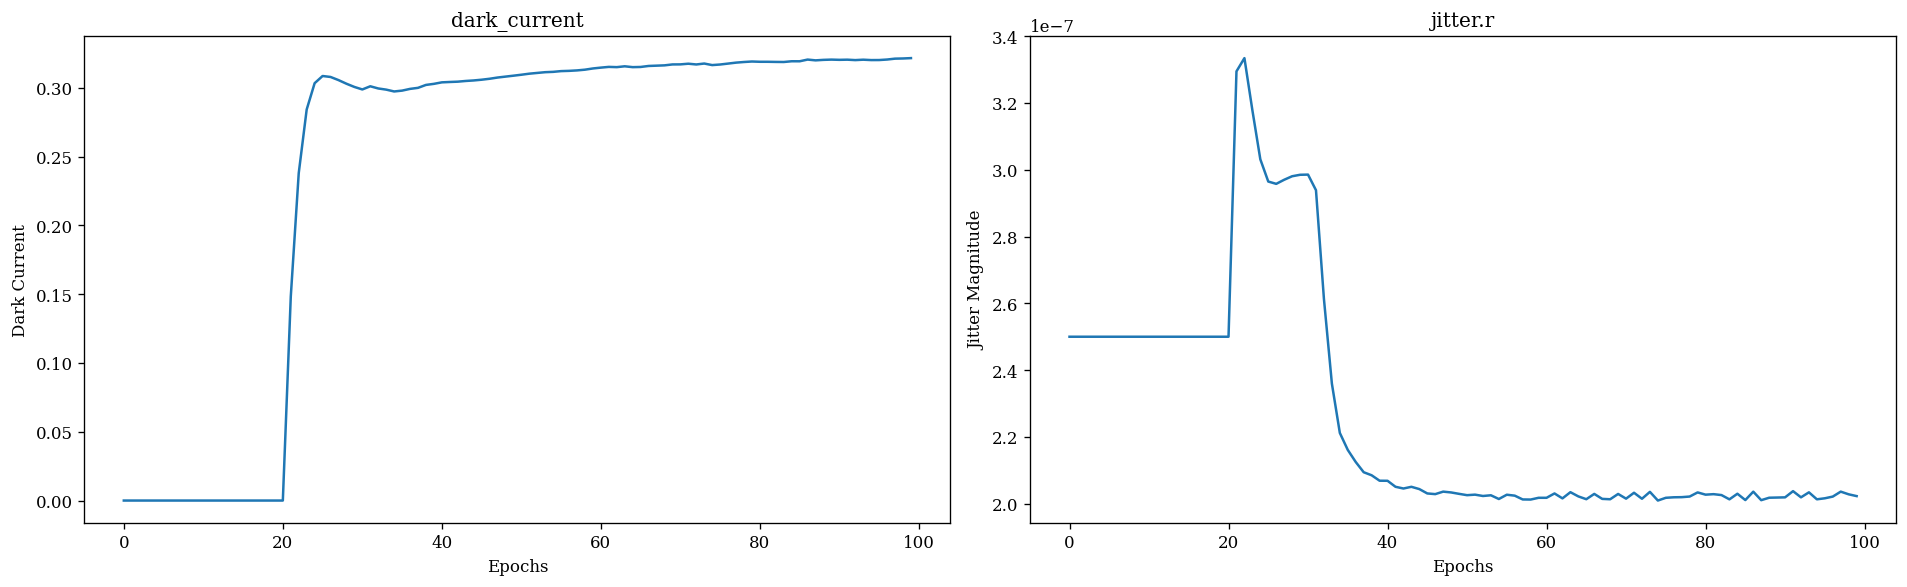

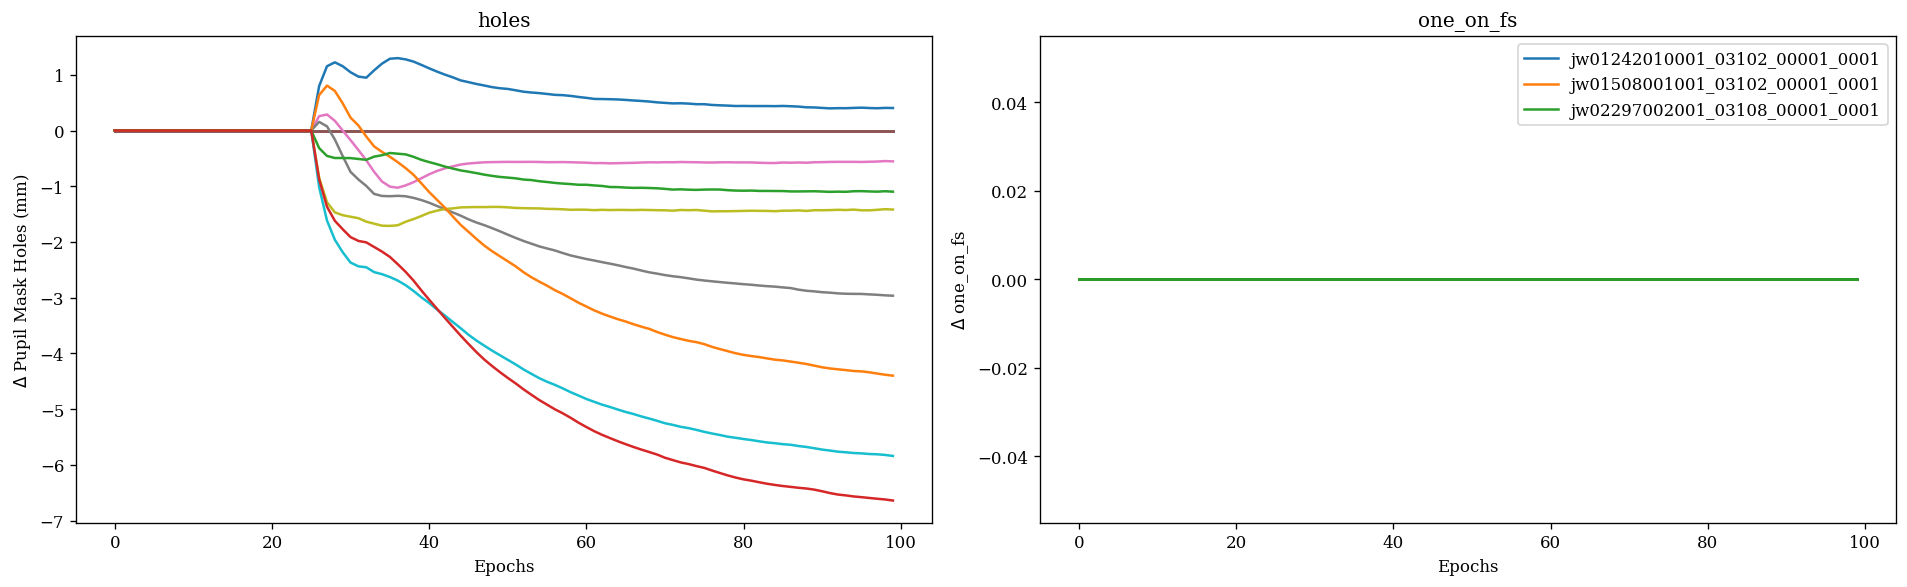

No formatting function for ramp.coeffs


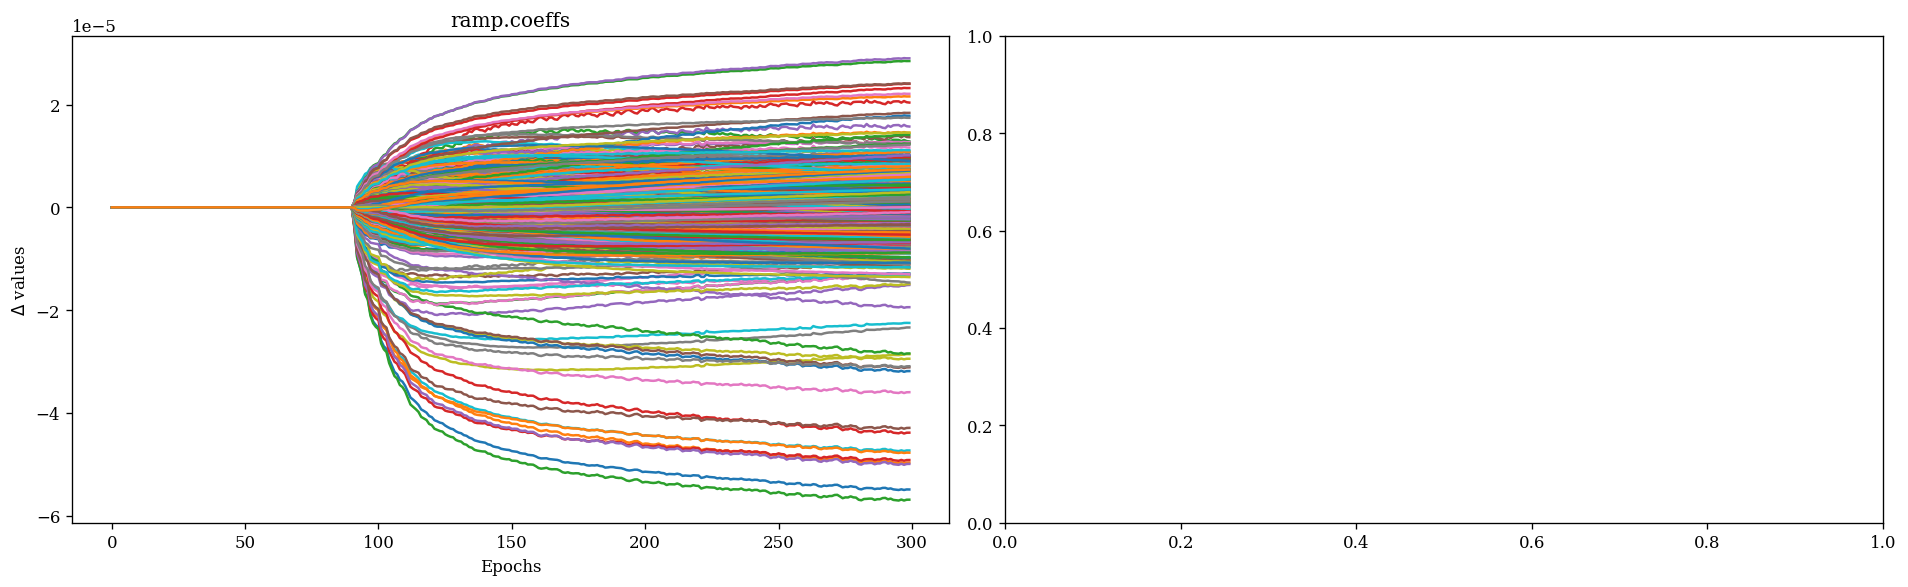

In [12]:
from amigo.plotting import plot, plot_losses

key_fn = lambda exp: f"{exp.ngroups:<3} {exp.nints} {np.nanmean(exp.data[-1]):<5.0f}"

print(losses[-1].mean(), losses[-1])
plot_losses(losses, start=20)
# plot_losses(losses, start=40)
# plot_losses(losses, start=60)

for history in histories:
    plot(history)

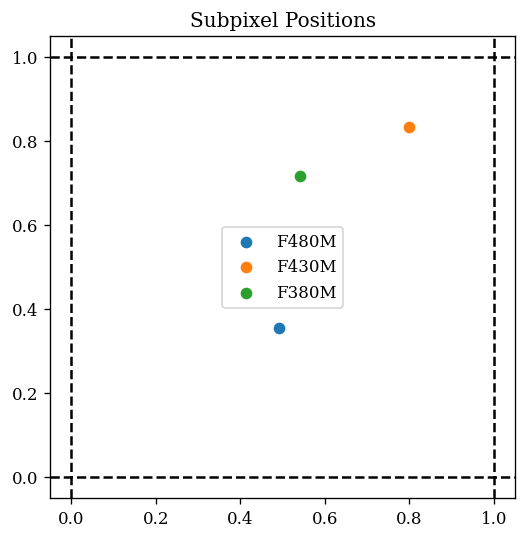

In [13]:
import jax.tree_util as jtu

subpix_pos = jtu.tree_map(
    lambda x: (x / model.optics.psf_pixel_scale) % 1, final_model.positions
)

colour_dict = {
    "F480M": 'tab:blue',
    "F430M": 'tab:orange',
    "F380M": 'tab:green',
}

plt.figure(figsize=(5, 5))
plt.title("Subpixel Positions")
for exp in exposures:
    plt.scatter(*subpix_pos[exp.key], c=colour_dict[exp.filter])

for filter, col in colour_dict.items():
    plt.scatter([], [], c=col, label=filter)

plt.legend()

plt.axhline(0, color="k", linestyle="--")
plt.axvline(0, color="k", linestyle="--")
plt.axhline(1, color="k", linestyle="--")
plt.axvline(1, color="k", linestyle="--")
plt.show()

File jw01508001001_03102_00001_0001
Star -GAM-MUS
Filter F380M
nints 4750
ngroups 3



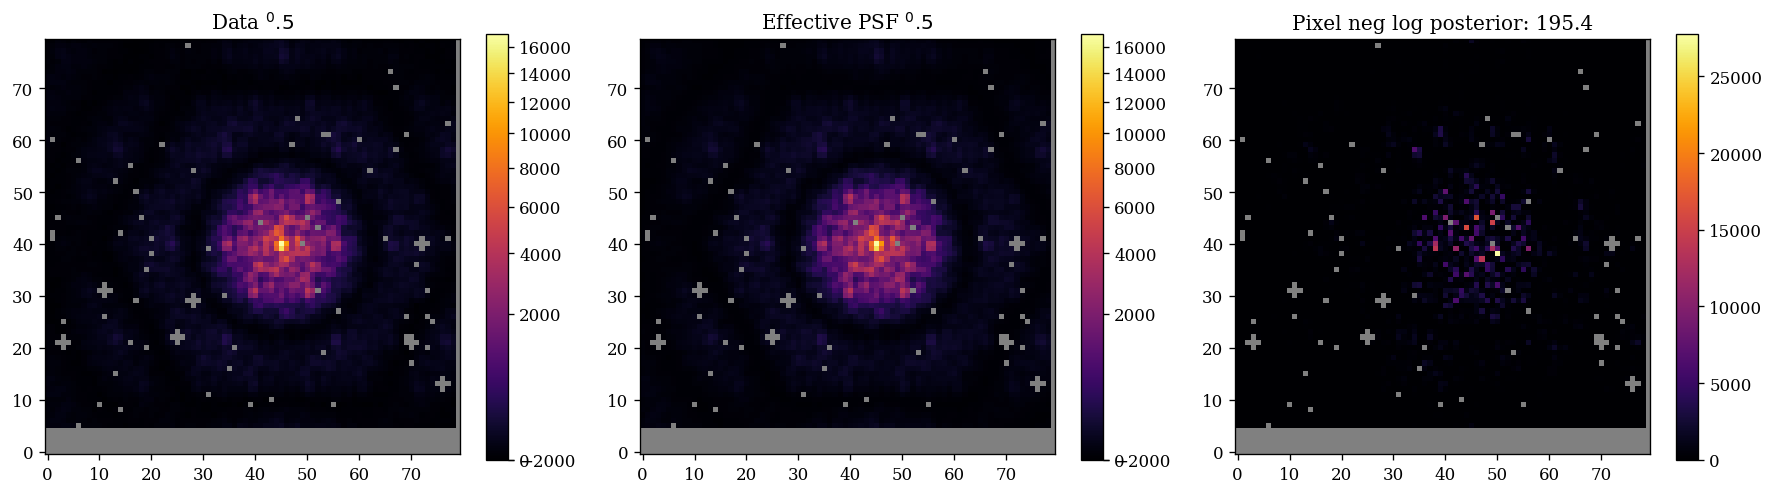

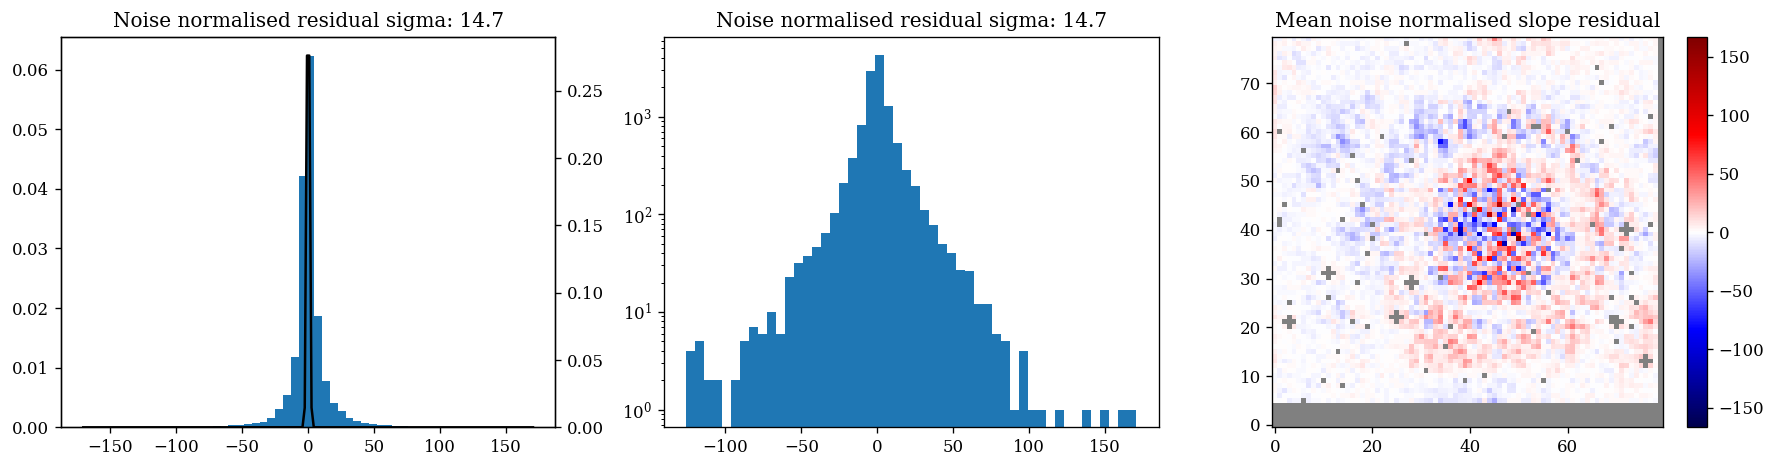

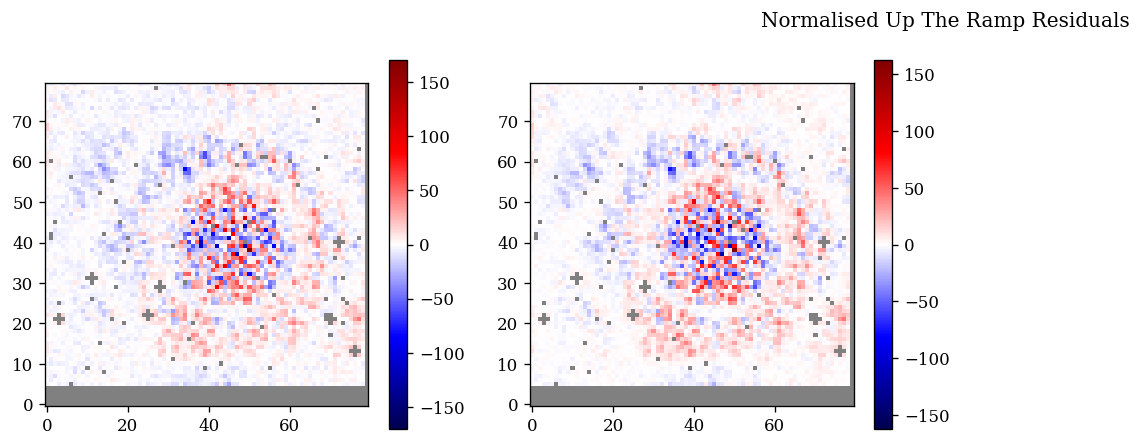

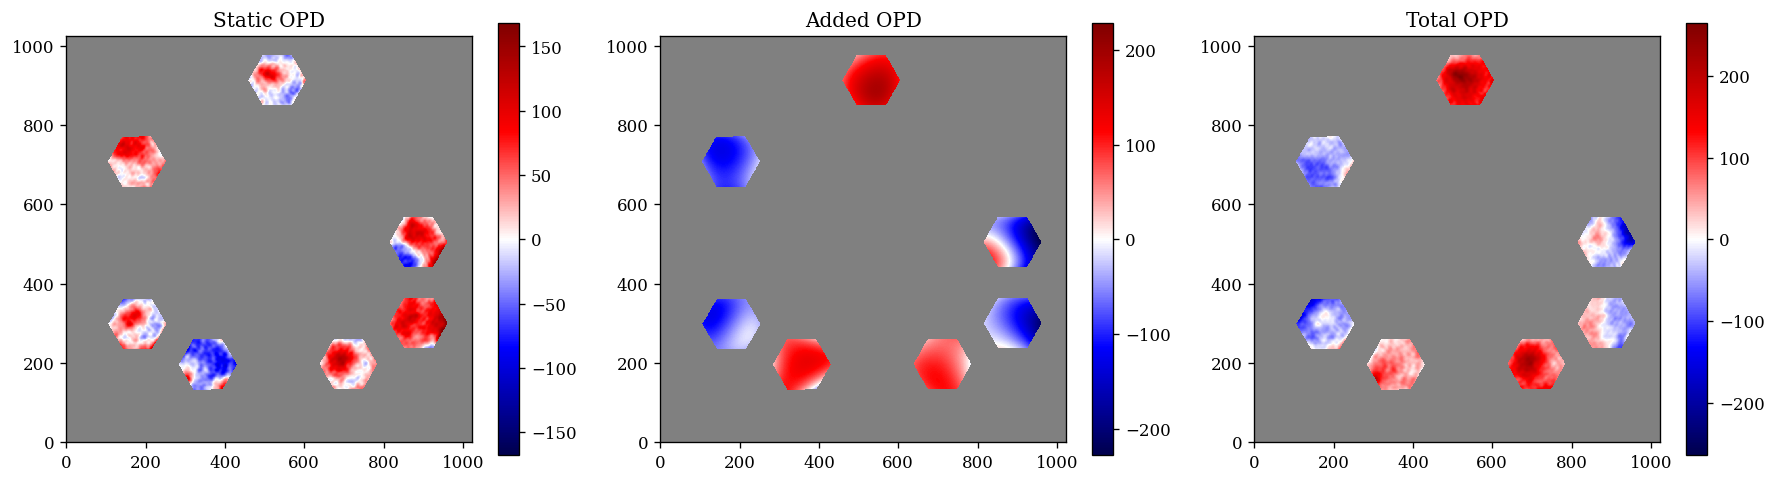

File jw02297002001_03108_00001_0001
Star HD-40733
Filter F430M
nints 5101
ngroups 3



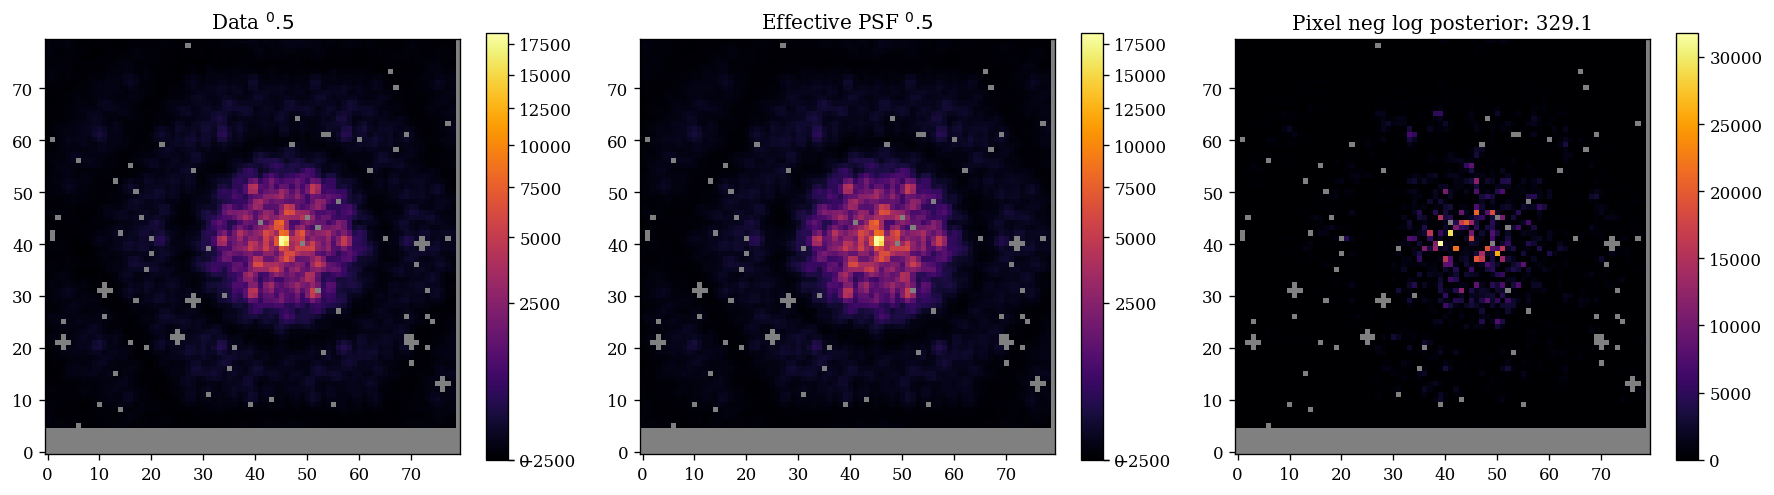

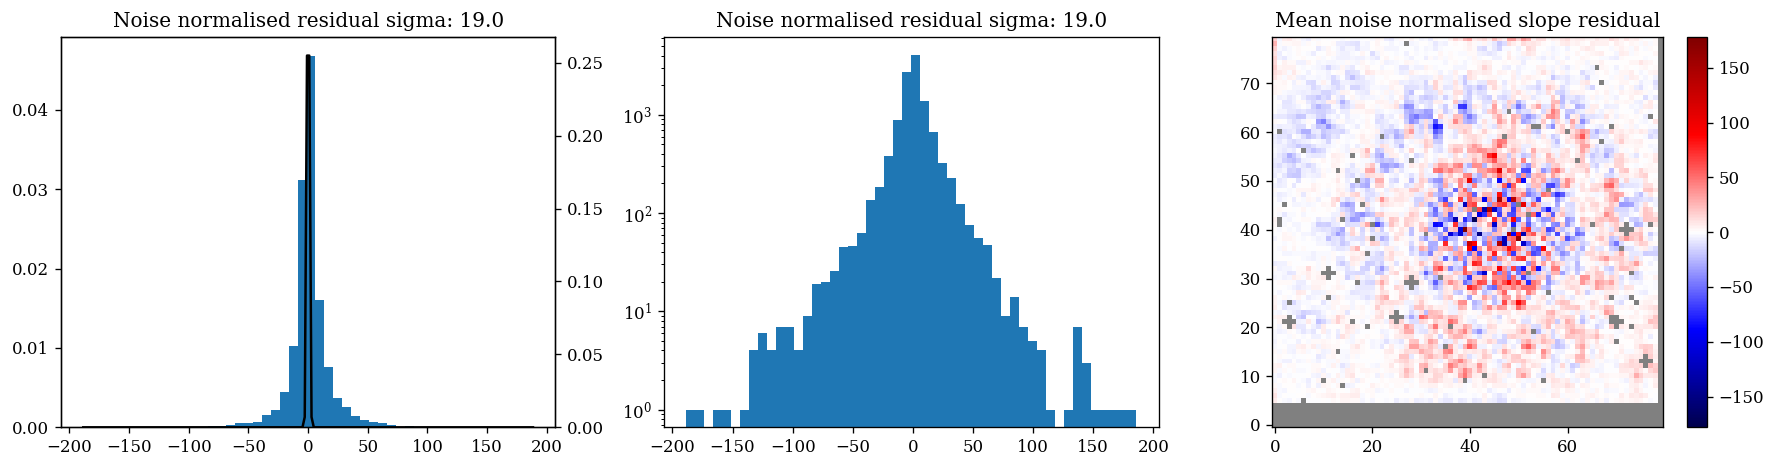

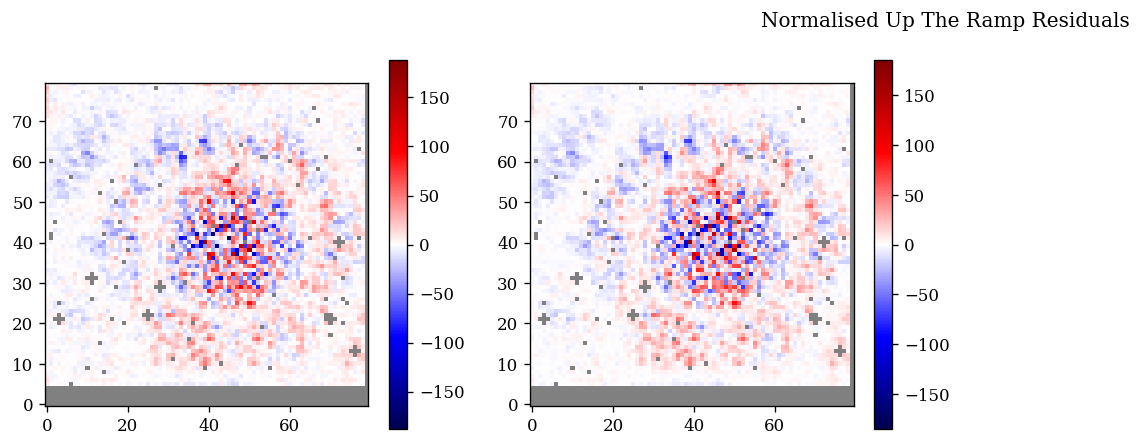

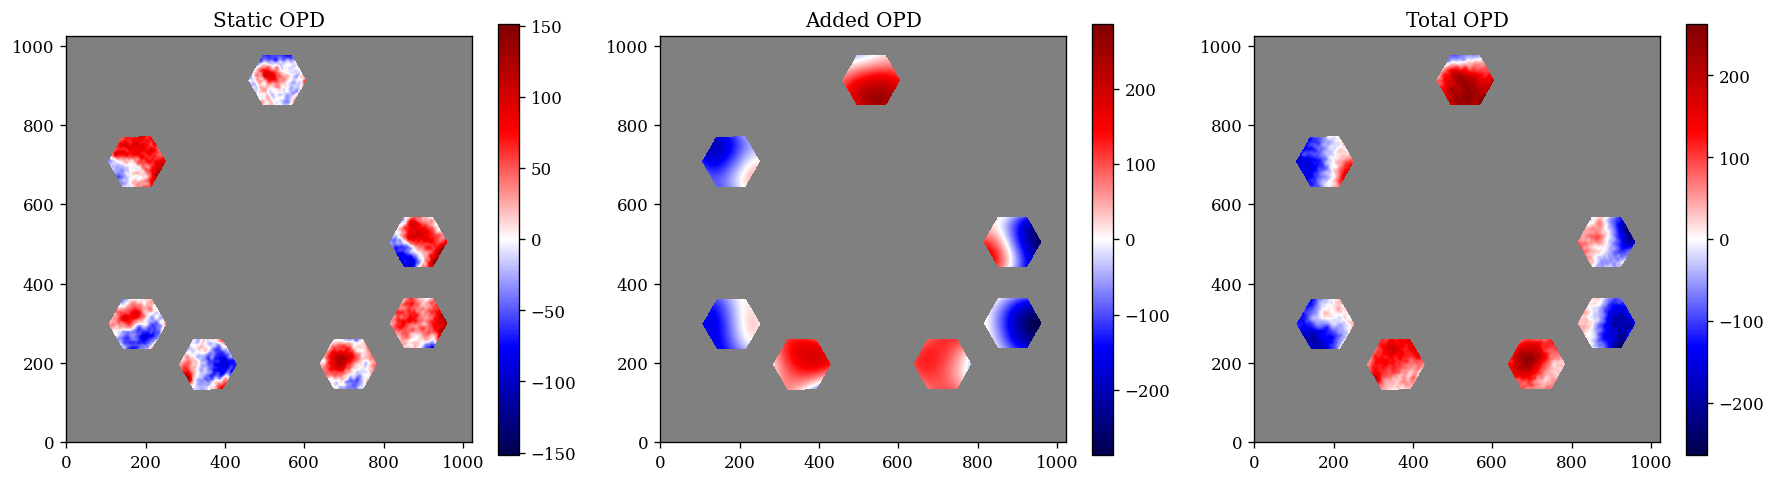

File jw01242010001_03102_00001_0001
Star HD-18638
Filter F480M
nints 4869
ngroups 8



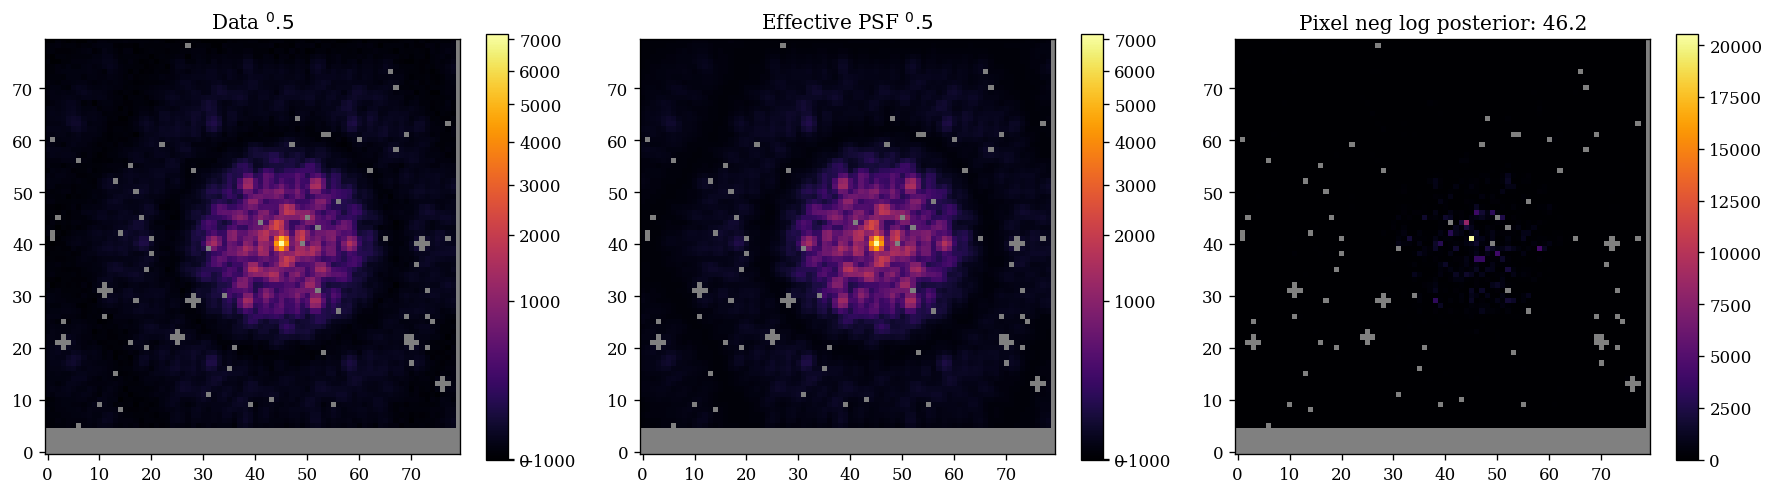

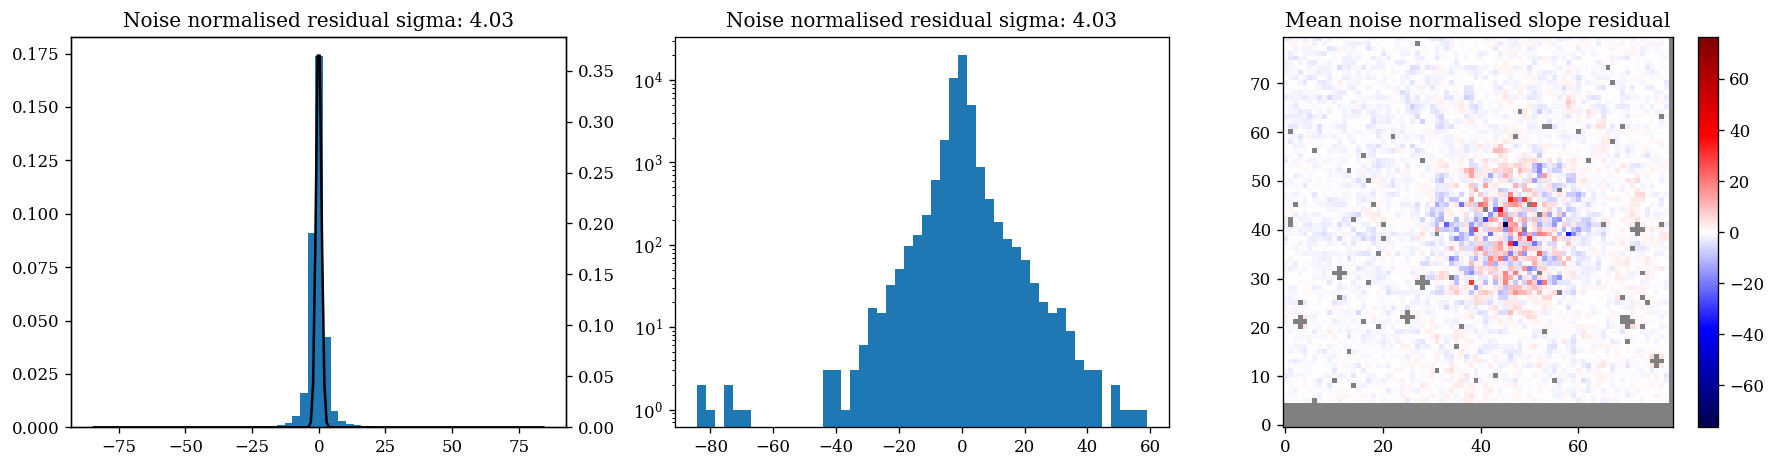

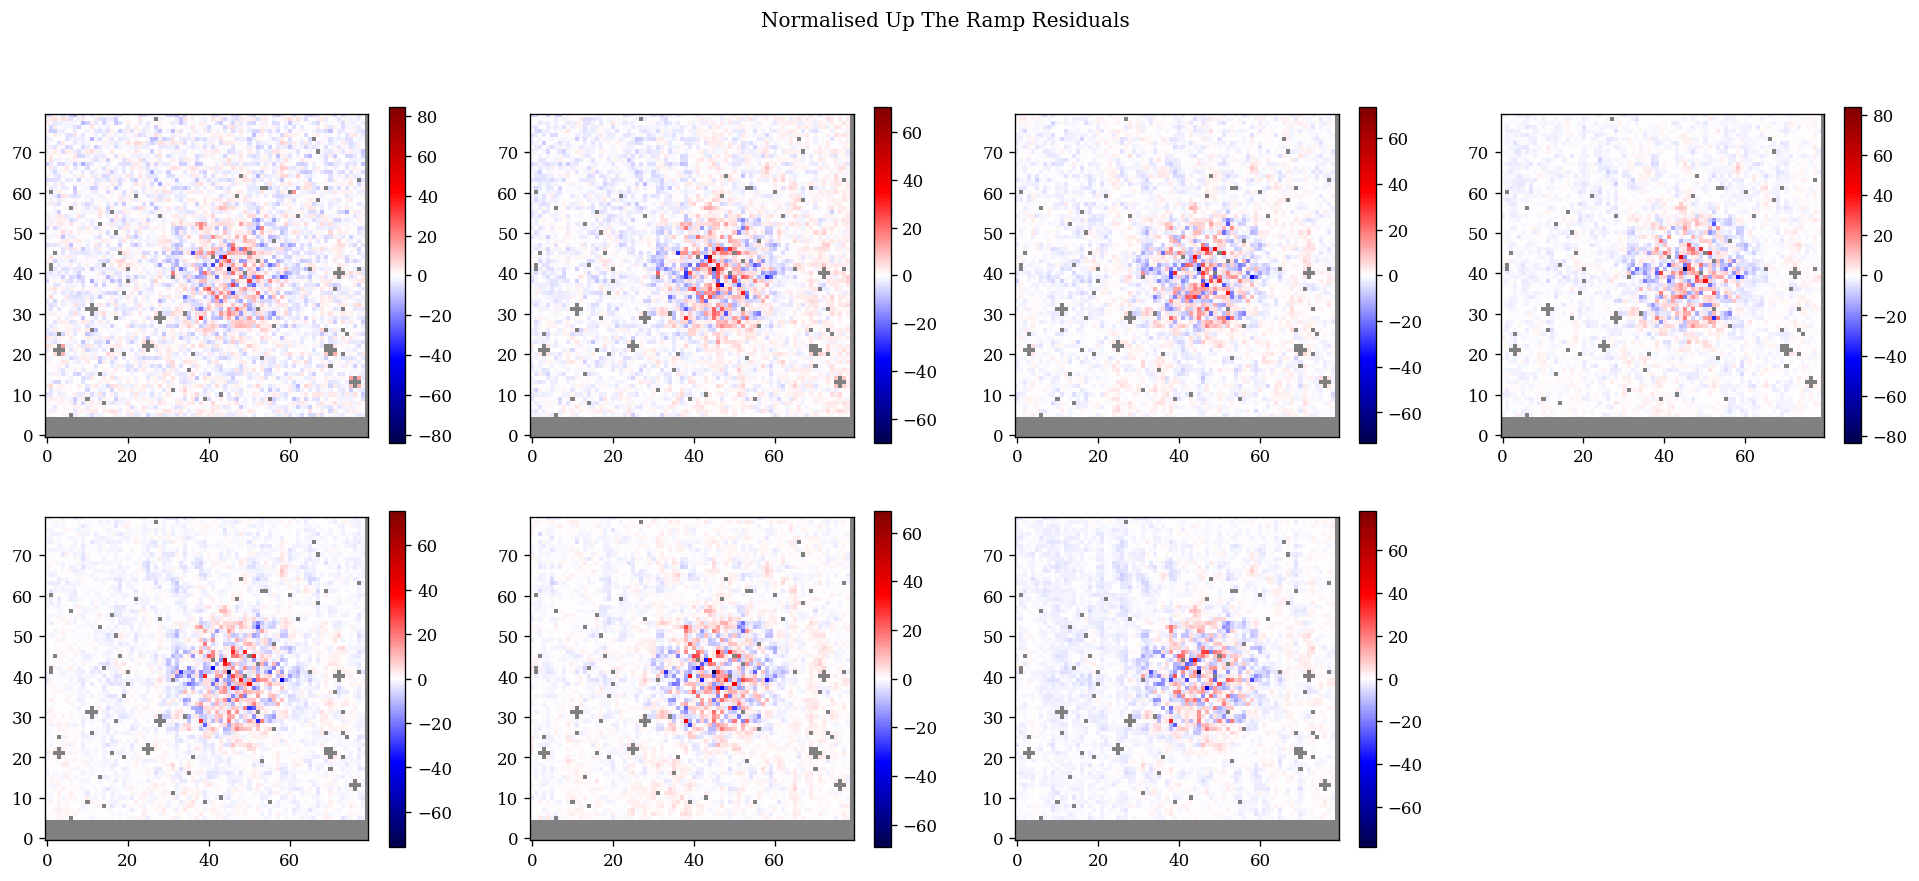

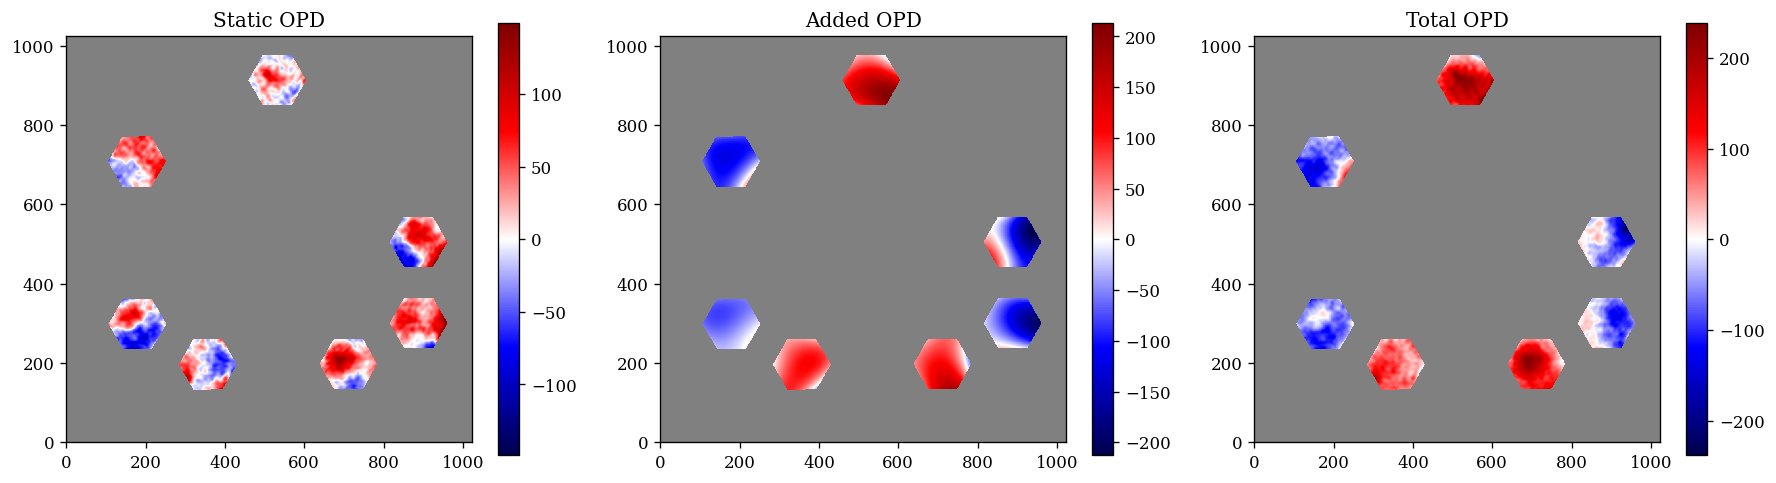

In [22]:
for exp in exposures:
    exp.print_summary()
    summarise_fit(
        exp, 
        final_model,
        residuals=True,
        histograms=True,
        # flat_field=True,
        # up_the_ramp=True,
        up_the_ramp_norm=True,
        # full_bias=True,
        aberrations=True,
    )

File jw01508001001_03102_00001_0001
Star -GAM-MUS
Filter F380M
nints 4750
ngroups 3



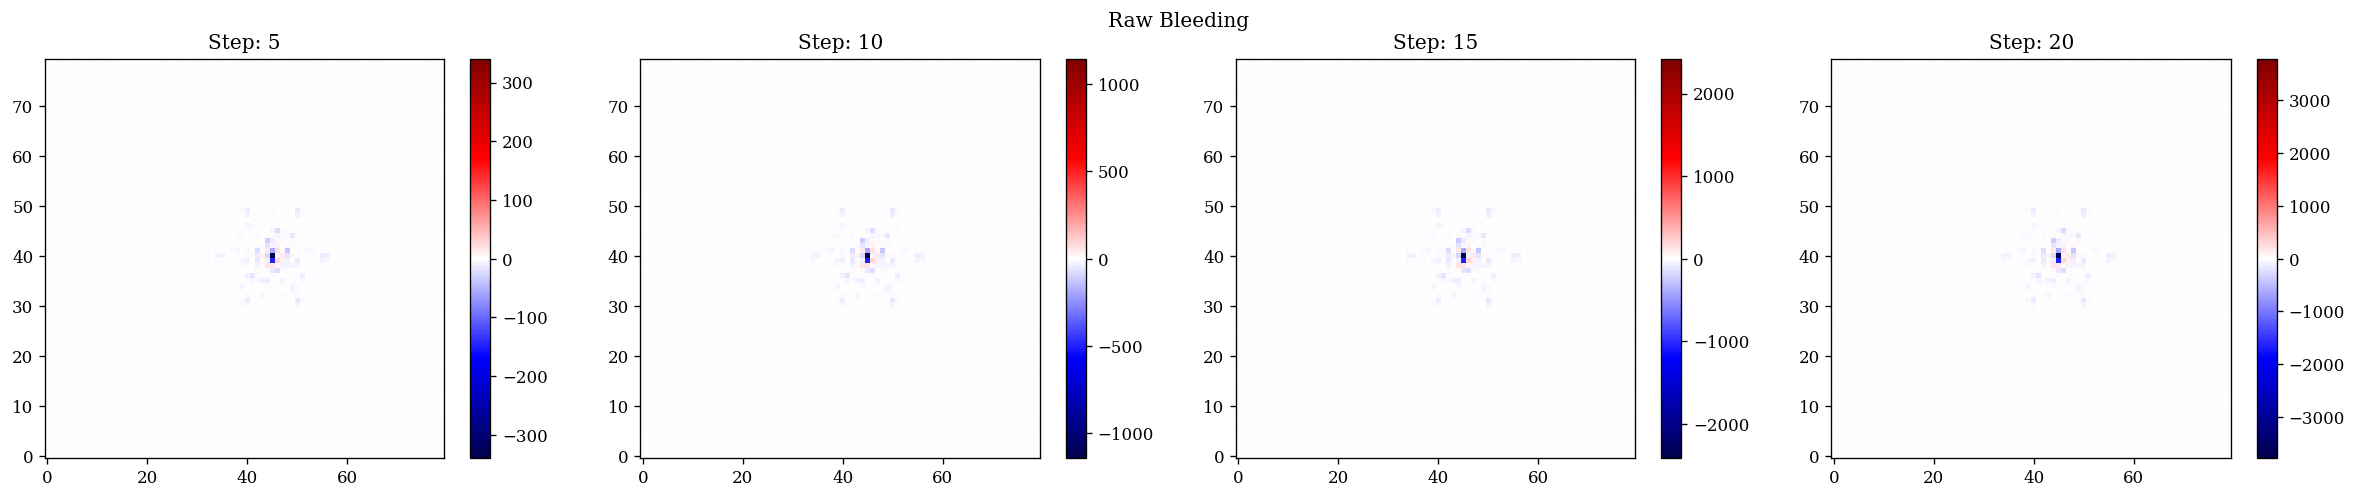

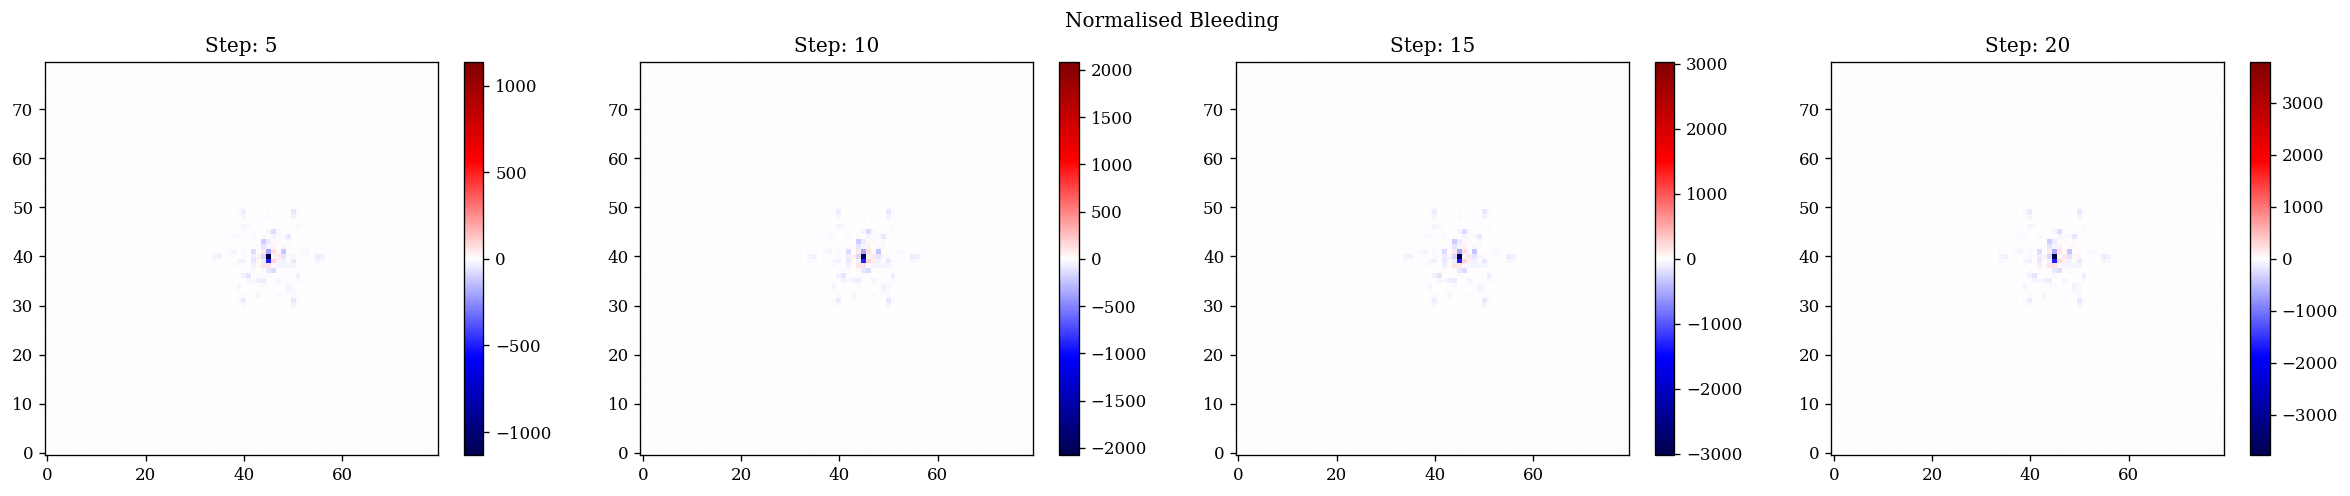

File jw02297002001_03108_00001_0001
Star HD-40733
Filter F430M
nints 5101
ngroups 3



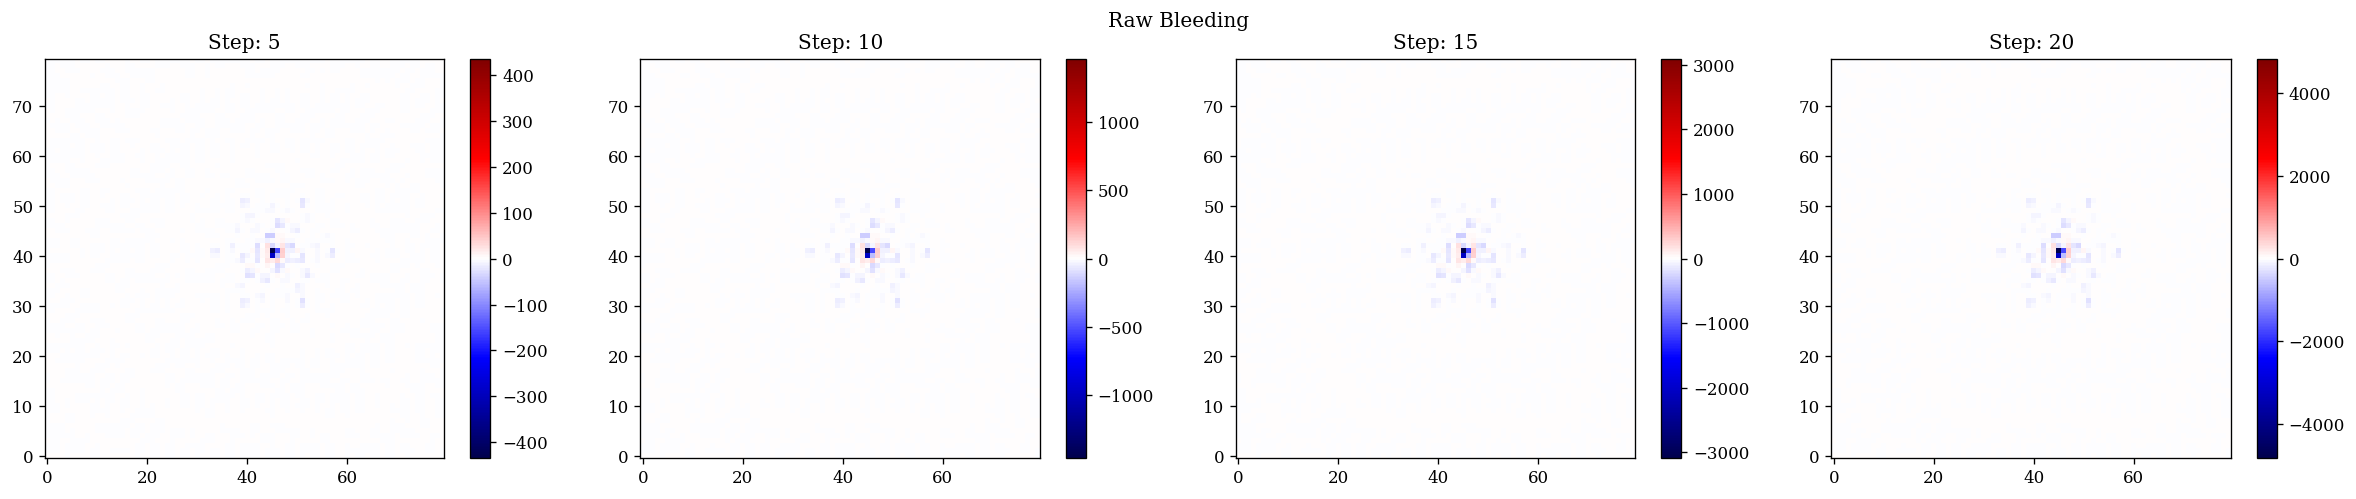

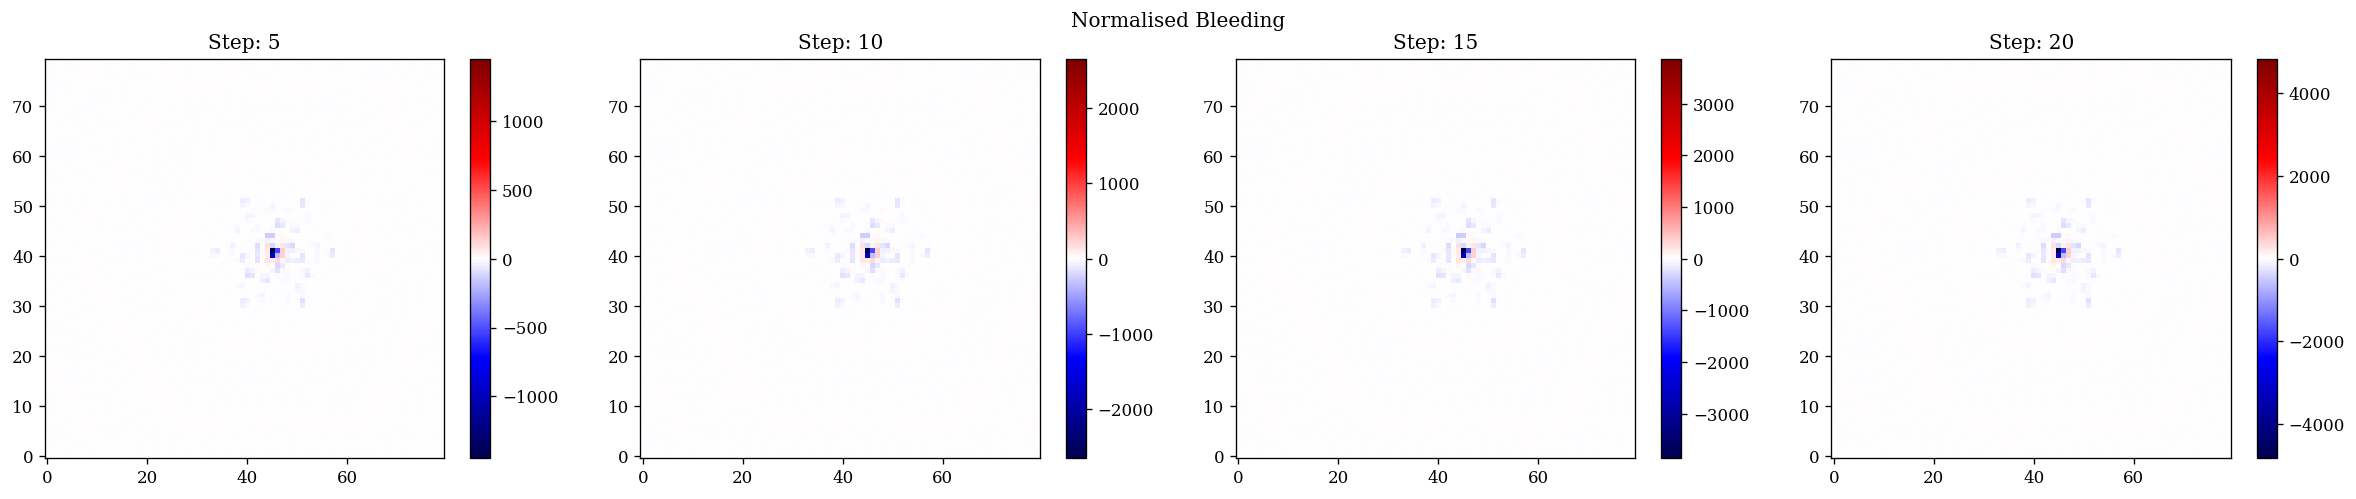

File jw01242010001_03102_00001_0001
Star HD-18638
Filter F480M
nints 4869
ngroups 8



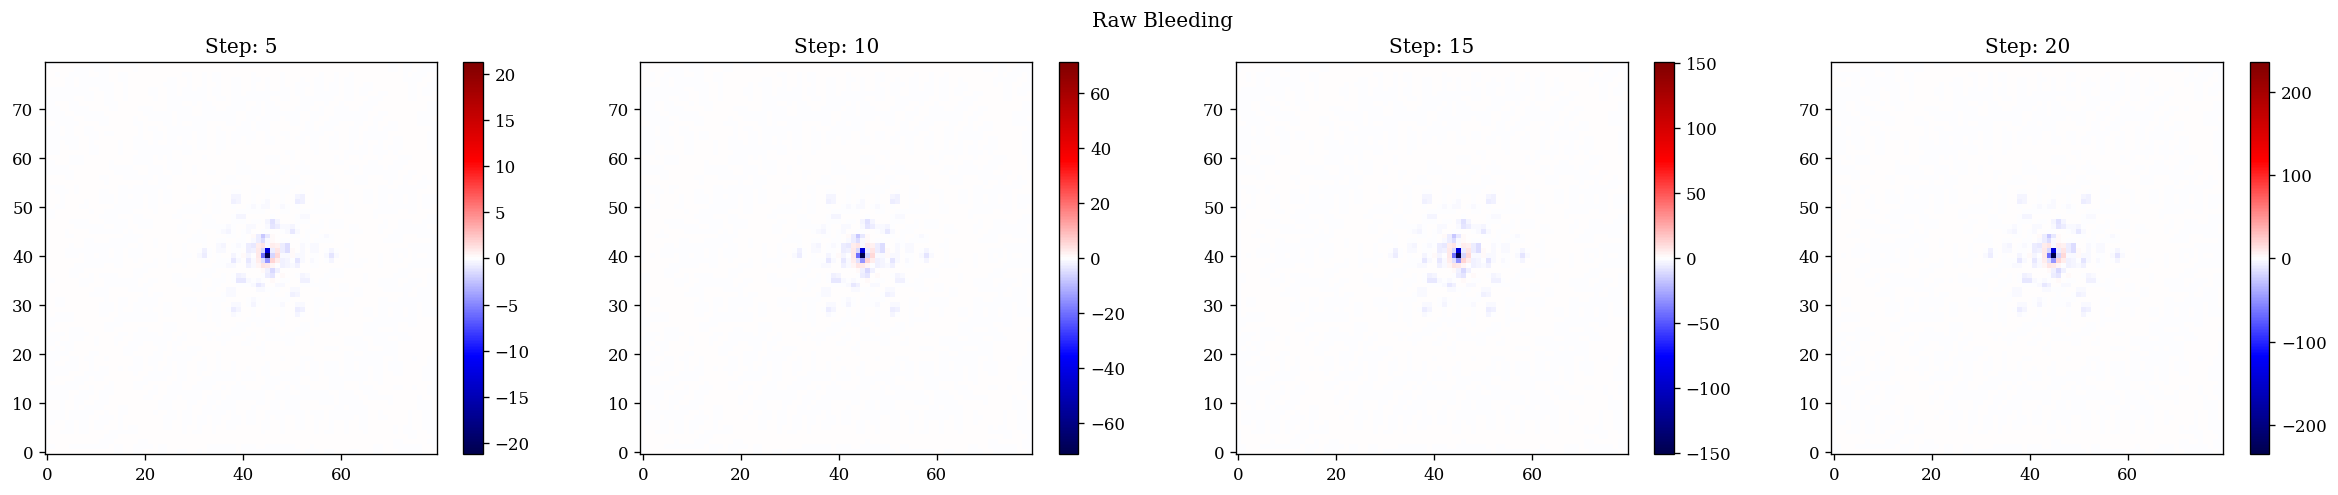

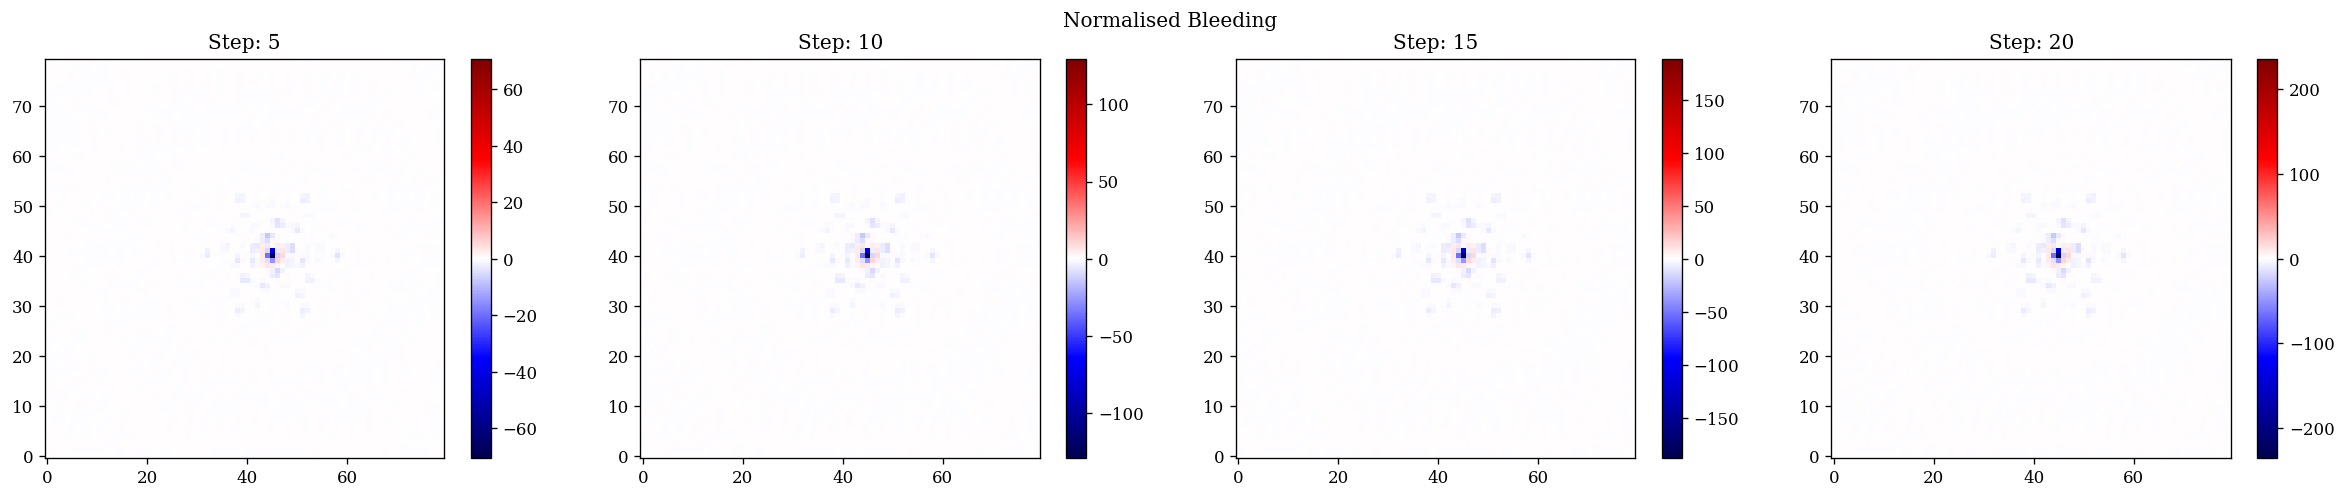

In [15]:
from amigo.modelling import model_ramp
from jax import vmap

for exp in exposures:
    exp.print_summary()
    psf, flux, oversample = final_model.model(exp, to_BFE=True)
    ramp = model_ramp(psf.data * flux, 20)
    bleed_ramp = vmap(final_model.ramp.calculate_bleeding)(ramp)

    ramp_vals = (np.arange(len(bleed_ramp)) + 1) / len(bleed_ramp)
    inv_ramp = 1 / ramp_vals

    inds = [5, 10, 15, 20]
    plt.figure(figsize=(20, 4))
    plt.suptitle("Raw Bleeding")
    for i in range(4):
        idx = inds[i]
        plt.subplot(1, 4, i + 1)
        bleed = bleed_ramp[idx]
        v = np.nanmax(np.abs(bleed))
        plt.title(f"Step: {idx}")
        plt.imshow(bleed, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.suptitle("Normalised Bleeding")
    for i in range(4):
        idx = inds[i]
        plt.subplot(1, 4, i + 1)
        bleed = bleed_ramp[idx] * inv_ramp[idx]
        v = np.nanmax(np.abs(bleed))
        plt.title(f"Step: {idx}")
        plt.imshow(bleed, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

In [16]:
np.save("files/poly_coeffs", model.ramp.coeffs)

In [17]:
import os
from datetime import date


def create_folder():
    root_path = 'files/models/'

    # Get the current date as a string
    current_date = str(date.today())
    base_path = root_path + current_date

    # Check if a folder with the current date exists, and if not, create it
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Get a list of all directories in the current date folder
    dirs = [
        d
        for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
    ]

    # Filter out directories that can't be converted to integers
    dirs = [d for d in dirs if d.isdigit()]

    # Convert the directory names to integers
    dirs = [int(d) for d in dirs]

    # Find the lowest integer that doesn't exist in the list
    next_int = 0
    while next_int in dirs:
        next_int += 1

    # Create a directory with the next integer
    next_dir = os.path.join(base_path, str(next_int))
    os.makedirs(next_dir)

    os.makedirs(next_dir + "/exposures/")

    return next_dir

In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
from zodiax.experimental import serialise


save_path = create_folder()

# eqx.tree_serialise_leaves(f"{save_path}/CNN_BFE.eqx", final_model.BFE)
serialise(f"{save_path}/BFE", final_model.BFE)
serialise(f"{save_path}/AMI_mask", final_model.pupil_mask)
serialise(f"{save_path}/anisotropy", final_model.anisotropy)
serialise(f"{save_path}/reflectivities", final_model.optics.holes)
np.save(f"{save_path}/dark_current", final_model.detector.dark_current)


# for exp in exposures:
#     key = exp.key
# exp = exp.set('bias', model.biases[key])
# exp = exp.set('one_on_fs', model.one_on_fs[key])
# exp = exp.set('position', model.positions[key])
# exp = exp.set("aberrations", model.aberrations[key])
# exp = exp.set('flux', model.fluxes[key])
# serialise(f"{save_path}/exposures/{key}", exp)

print(save_path)

files/models/2024-04-23/0


In [ ]:
100 % -1

0